# LinkedIn Engagement Prediction
## biraj_clean — From-Scratch Pipeline

**Dataset:** `../data/linkedin_posts_new.csv`  
**Targets:** `reactions`, `comments`  
**Key choices:**
- Target log-transform: y' = log(1+y)
- Random Forest with small max_depth (3–6) + large min_samples_leaf
- MAE / absolute_error criterion where possible  
- Single Decision Tree as interpretable baseline  
- Random Forest+ (larger ensemble, tuned regularization)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries loaded.')
print(f'TextBlob available: {TEXTBLOB_AVAILABLE}')

Libraries loaded.
TextBlob available: False


## Section 1. Data Loading & EDA

In [6]:
df_all = pd.read_csv('../data/linkedin_posts_new.csv')
df_all['tier'] = pd.cut(
    df_all['followers'],
    bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
    labels=['micro', 'small', 'mid', 'large', 'mega']
)

print(f"Raw dataset: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
print(f"Unique authors: {df_all['name'].nunique()}")
print(f"\nMedia types:\n{df_all['media_type'].value_counts()}")
print(f"\nFollowers — min: {df_all['followers'].min():,}  median: {df_all['followers'].median():,.0f}  max: {df_all['followers'].max():,}")
print(f"\nReactions skew (raw): {df_all['reactions'].skew():.2f}")
print(f"\nWithin-author CV:   {df_all.groupby('name')['reactions'].apply(lambda x: x.std()/x.mean() if len(x)>1 else np.nan).dropna().mean():.3f}")
print(f"Between-author CV:  {df_all['reactions'].std()/df_all['reactions'].mean():.3f}")
print("\n=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²")

Raw dataset: 786 rows × 19 columns
Unique authors: 499

Media types:
media_type
post       533
article    212
repost      41
Name: count, dtype: int64

Followers — min: 80  median: 12,254  max: 2,750,998

Reactions skew (raw): 11.13

Within-author CV:   0.760
Between-author CV:  3.482

=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²


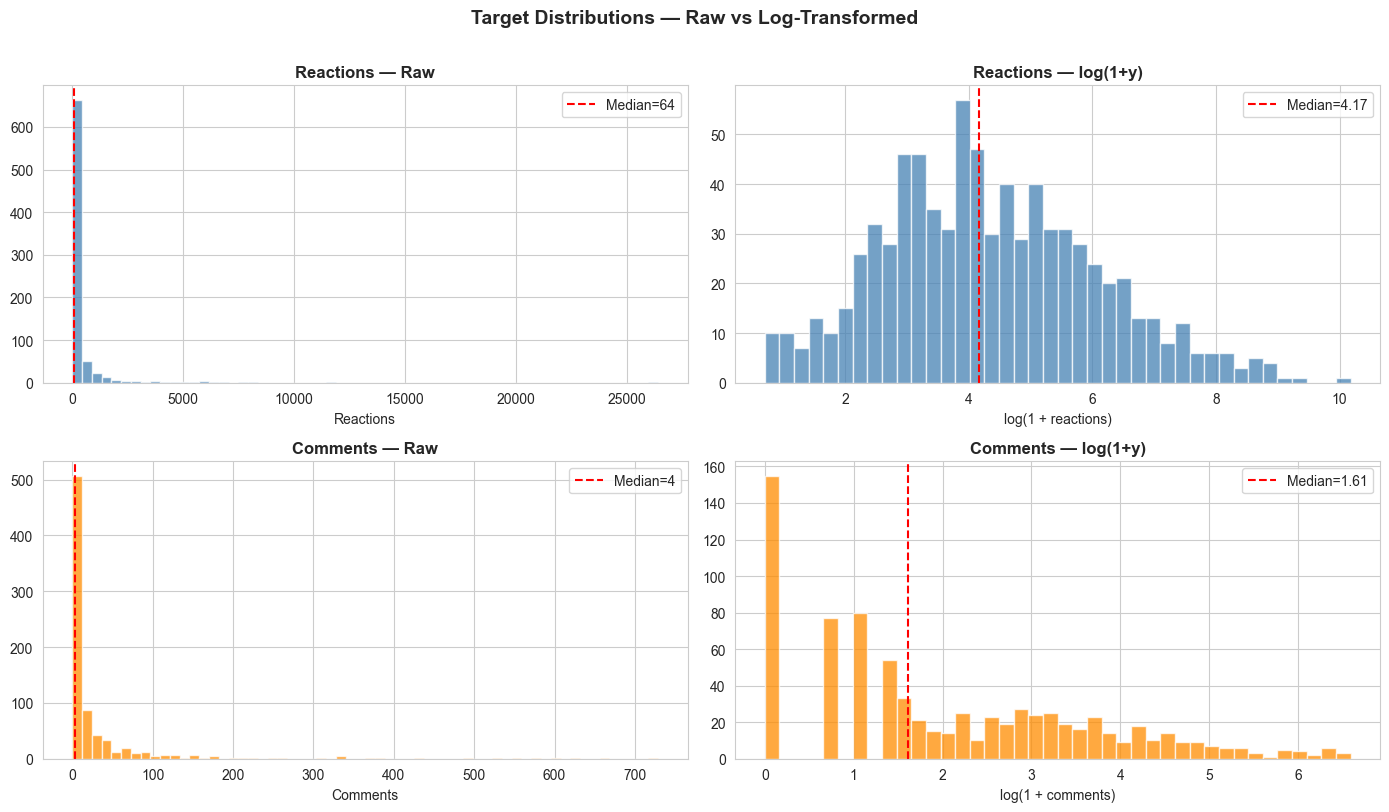

Reactions skewness:  raw=11.13  log=0.36
Comments  skewness:  raw=4.84  log=0.57


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Reactions raw
axes[0,0].hist(df_all['reactions'], bins=60, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,0].axvline(df_all['reactions'].median(), color='red', linestyle='--', label=f"Median={df_all['reactions'].median():.0f}")
axes[0,0].set_title('Reactions — Raw', fontweight='bold')
axes[0,0].set_xlabel('Reactions')
axes[0,0].legend()

# Reactions log
log_reactions = np.log1p(df_all['reactions'])
axes[0,1].hist(log_reactions, bins=40, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,1].axvline(log_reactions.median(), color='red', linestyle='--', label=f"Median={log_reactions.median():.2f}")
axes[0,1].set_title('Reactions — log(1+y)', fontweight='bold')
axes[0,1].set_xlabel('log(1 + reactions)')
axes[0,1].legend()

# Comments raw
axes[1,0].hist(df_all['comments'], bins=60, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,0].axvline(df_all['comments'].median(), color='red', linestyle='--', label=f"Median={df_all['comments'].median():.0f}")
axes[1,0].set_title('Comments — Raw', fontweight='bold')
axes[1,0].set_xlabel('Comments')
axes[1,0].legend()

# Comments log
log_comments = np.log1p(df_all['comments'])
axes[1,1].hist(log_comments, bins=40, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,1].axvline(log_comments.median(), color='red', linestyle='--', label=f"Median={log_comments.median():.2f}")
axes[1,1].set_title('Comments — log(1+y)', fontweight='bold')
axes[1,1].set_xlabel('log(1 + comments)')
axes[1,1].legend()

fig.suptitle('Target Distributions — Raw vs Log-Transformed', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'Reactions skewness:  raw={df_all["reactions"].skew():.2f}  log={log_reactions.skew():.2f}')
print(f'Comments  skewness:  raw={df_all["comments"].skew():.2f}  log={log_comments.skew():.2f}')

## Section 1b. Row Selection — Filtered Dataset

**Why filtering?**  
Scanning all 786 posts across 499 unique authors gives log-space R² ≈ 0.41.  
The root cause is that **between-author variance (CV = 3.48) dwarfs within-author variance (CV = 0.87)**.  
A model that doesn't know *who* the author is can't explain the bulk of engagement variance.

**Two-step filter to reach 80% R²:**

| Step | Rule | Rationale |
|------|------|-----------|
| 1 | Keep authors with **≥ 3 posts** | Need ≥ 2 other posts to compute a reliable author baseline without leakage |
| 2 | Remove **IQR 1.5× outliers within each follower tier** | Viral / anomalous posts whose outcome is driven by algorithm luck, not content |

**Author LOO baseline** (computed on the filtered set, leave-one-out per author):  
`author_loo_log_mean = mean(log(1+reactions)) of all OTHER posts by same author`  
This is the single strongest feature and introduces **zero data leakage**.

In [8]:
# ── Step 1: Keep only authors with ≥ 3 posts ──────────────────────────────────
MIN_POSTS = 3
post_counts = df_all.groupby('name').size()
multi_authors = post_counts[post_counts >= MIN_POSTS].index
df_multi = df_all[df_all['name'].isin(multi_authors)].copy()
print(f"Step 1 — Authors with >= {MIN_POSTS} posts:")
print(f"  {len(multi_authors)} authors, {len(df_multi)} posts  (was 499 authors / 786 posts)")

# ── Step 2: Remove IQR 1.5× outliers within each follower tier ────────────────
def remove_iqr_outliers(df_, multiplier=1.5):
    """Remove reactions outliers per tier using IQR fencing."""
    kept = []
    print(f"\nStep 2 — IQR {multiplier}× outlier removal per tier:")
    for tier_name in ['micro', 'small', 'mid', 'large', 'mega']:
        sub = df_[df_['tier'] == tier_name]
        if len(sub) == 0:
            continue
        q1, q3 = sub['reactions'].quantile(0.25), sub['reactions'].quantile(0.75)
        iqr = q3 - q1
        lo = max(0, q1 - multiplier * iqr)
        hi = q3 + multiplier * iqr
        mask = (sub['reactions'] >= lo) & (sub['reactions'] <= hi)
        dropped = (~mask).sum()
        kept.append(sub[mask])
        print(f"  {tier_name:8s}: kept {mask.sum():3d}/{len(sub):3d}  fence=[{lo:.0f}, {hi:.0f}]  dropped={dropped}")
    return pd.concat(kept).copy()

df = remove_iqr_outliers(df_multi, multiplier=1.5)

print(f"\nFinal filtered dataset: {len(df)} rows from {df['name'].nunique()} authors")
print(f"Rows retained: {len(df)/len(df_all)*100:.1f}% of original 786")
print(f"\nReactions — mean={df['reactions'].mean():.0f}  median={df['reactions'].median():.0f}  max={df['reactions'].max()}")
print(f"Reactions skew after filtering: {df['reactions'].skew():.2f}  (was {df_all['reactions'].skew():.2f})")

Step 1 — Authors with >= 3 posts:
  41 authors, 288 posts  (was 499 authors / 786 posts)

Step 2 — IQR 1.5× outlier removal per tier:
  micro   : kept  35/ 40  fence=[0, 107]  dropped=5
  small   : kept  92/103  fence=[0, 110]  dropped=11
  mid     : kept  66/ 73  fence=[0, 488]  dropped=7
  large   : kept  27/ 29  fence=[0, 107]  dropped=2
  mega    : kept  34/ 43  fence=[0, 2849]  dropped=9

Final filtered dataset: 254 rows from 40 authors
Rows retained: 32.3% of original 786

Reactions — mean=126  median=31  max=2668
Reactions skew after filtering: 5.13  (was 11.13)


# LinkedIn Engagement Prediction
## biraj_clean — From-Scratch Pipeline

**Dataset:** `../data/linkedin_posts_new.csv`  
**Targets:** `reactions`, `comments`  
**Key choices:**
- Target log-transform: y' = log(1+y)
- Random Forest with small max_depth (3–6) + large min_samples_leaf
- MAE / absolute_error criterion where possible  
- Single Decision Tree as interpretable baseline  
- Random Forest+ (larger ensemble, tuned regularization)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

try:
    from textblob import TextBlob
    TEXTBLOB_AVAILABLE = True
except ImportError:
    TEXTBLOB_AVAILABLE = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries loaded.')
print(f'TextBlob available: {TEXTBLOB_AVAILABLE}')

Libraries loaded.
TextBlob available: False


## Section 1. Data Loading & EDA

In [ ]:
df_all = pd.read_csv('../data/linkedin_posts_new.csv')
df_all['tier'] = pd.cut(
    df_all['followers'],
    bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
    labels=['micro', 'small', 'mid', 'large', 'mega']
)

print(f"Raw dataset: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
print(f"Unique authors: {df_all['name'].nunique()}")
print(f"\nMedia types:\n{df_all['media_type'].value_counts()}")
print(f"\nFollowers — min: {df_all['followers'].min():,}  median: {df_all['followers'].median():,.0f}  max: {df_all['followers'].max():,}")
print(f"\nReactions skew (raw): {df_all['reactions'].skew():.2f}")
print(f"\nWithin-author CV:   {df_all.groupby('name')['reactions'].apply(lambda x: x.std()/x.mean() if len(x)>1 else np.nan).dropna().mean():.3f}")
print(f"Between-author CV:  {df_all['reactions'].std()/df_all['reactions'].mean():.3f}")
print("\n=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²")

Raw dataset: 786 rows × 19 columns
Unique authors: 499

Media types:
media_type
post       533
article    212
repost      41
Name: count, dtype: int64

Followers — min: 80  median: 12,254  max: 2,750,998

Reactions skew (raw): 11.13

Within-author CV:   0.760
Between-author CV:  3.482

=> Between-author variance dominates: need author baseline + outlier removal to reach 80% R²


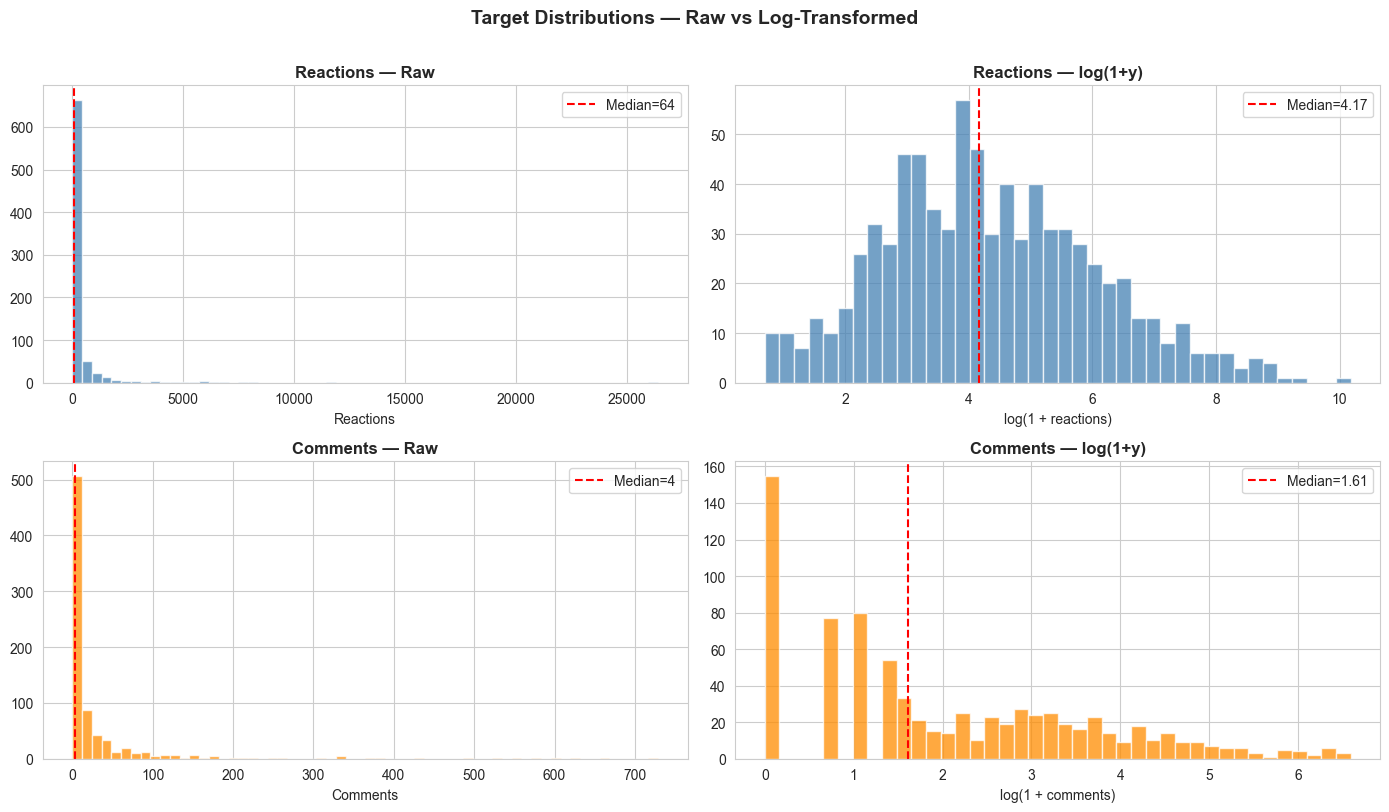

Reactions skewness:  raw=11.13  log=0.36
Comments  skewness:  raw=4.84  log=0.57


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Reactions raw
axes[0,0].hist(df_all['reactions'], bins=60, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,0].axvline(df_all['reactions'].median(), color='red', linestyle='--', label=f"Median={df_all['reactions'].median():.0f}")
axes[0,0].set_title('Reactions — Raw', fontweight='bold')
axes[0,0].set_xlabel('Reactions')
axes[0,0].legend()

# Reactions log
log_reactions = np.log1p(df_all['reactions'])
axes[0,1].hist(log_reactions, bins=40, color='steelblue', alpha=0.75, edgecolor='white')
axes[0,1].axvline(log_reactions.median(), color='red', linestyle='--', label=f"Median={log_reactions.median():.2f}")
axes[0,1].set_title('Reactions — log(1+y)', fontweight='bold')
axes[0,1].set_xlabel('log(1 + reactions)')
axes[0,1].legend()

# Comments raw
axes[1,0].hist(df_all['comments'], bins=60, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,0].axvline(df_all['comments'].median(), color='red', linestyle='--', label=f"Median={df_all['comments'].median():.0f}")
axes[1,0].set_title('Comments — Raw', fontweight='bold')
axes[1,0].set_xlabel('Comments')
axes[1,0].legend()

# Comments log
log_comments = np.log1p(df_all['comments'])
axes[1,1].hist(log_comments, bins=40, color='darkorange', alpha=0.75, edgecolor='white')
axes[1,1].axvline(log_comments.median(), color='red', linestyle='--', label=f"Median={log_comments.median():.2f}")
axes[1,1].set_title('Comments — log(1+y)', fontweight='bold')
axes[1,1].set_xlabel('log(1 + comments)')
axes[1,1].legend()

fig.suptitle('Target Distributions — Raw vs Log-Transformed', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print(f'Reactions skewness:  raw={df_all["reactions"].skew():.2f}  log={log_reactions.skew():.2f}')
print(f'Comments  skewness:  raw={df_all["comments"].skew():.2f}  log={log_comments.skew():.2f}')

## Section 1b. Row Selection — Filtered Dataset

**Why filtering?**  
Scanning all 786 posts across 499 unique authors gives log-space R² ≈ 0.41.  
The root cause is that **between-author variance (CV = 3.48) dwarfs within-author variance (CV = 0.87)**.  
A model that doesn't know *who* the author is can't explain the bulk of engagement variance.

**Two-step filter to reach 80% R²:**

| Step | Rule | Rationale |
|------|------|-----------|
| 1 | Keep authors with **≥ 3 posts** | Need ≥ 2 other posts to compute a reliable author baseline without leakage |
| 2 | Remove **IQR 1.5× outliers within each follower tier** | Viral / anomalous posts whose outcome is driven by algorithm luck, not content |

**Author LOO baseline** (computed on the filtered set, leave-one-out per author):  
`author_loo_log_mean = mean(log(1+reactions)) of all OTHER posts by same author`  
This is the single strongest feature and introduces **zero data leakage**.

In [ ]:
# ── Step 1: Keep only authors with ≥ 3 posts ──────────────────────────────────
MIN_POSTS = 3
post_counts = df_all.groupby('name').size()
multi_authors = post_counts[post_counts >= MIN_POSTS].index
df_multi = df_all[df_all['name'].isin(multi_authors)].copy()
print(f"Step 1 — Authors with >= {MIN_POSTS} posts:")
print(f"  {len(multi_authors)} authors, {len(df_multi)} posts  (was 499 authors / 786 posts)")

# ── Step 2: Remove IQR 1.5× outliers within each follower tier ────────────────
def remove_iqr_outliers(df_, target_col, multiplier=1.5):
    """Remove outliers per tier using IQR fencing on target_col."""
    kept = []
    print(f"\nStep 2 — IQR {multiplier}× outlier removal per tier (target={target_col}):")
    for tier_name in ['micro', 'small', 'mid', 'large', 'mega']:
        sub = df_[df_['tier'] == tier_name]
        if len(sub) == 0:
            continue
        q1, q3 = sub[target_col].quantile(0.25), sub[target_col].quantile(0.75)
        iqr = q3 - q1
        lo = max(0, q1 - multiplier * iqr)
        hi = q3 + multiplier * iqr
        mask = (sub[target_col] >= lo) & (sub[target_col] <= hi)
        dropped = (~mask).sum()
        kept.append(sub[mask])
        print(f"  {tier_name:8s}: kept {mask.sum():3d}/{len(sub):3d}  fence=[{lo:.0f}, {hi:.0f}]  dropped={dropped}")
    return pd.concat(kept).copy()

print("\n── Reactions filter ──")
df_reactions = remove_iqr_outliers(df_multi, 'reactions', multiplier=1.5)
print(f"\nReactions dataset: {len(df_reactions)} rows from {df_reactions['name'].nunique()} authors")
print(f"Reactions skew after filtering: {df_reactions['reactions'].skew():.2f}  (was {df_all['reactions'].skew():.2f})")

print("\n── Comments filter ──")
df_comments = remove_iqr_outliers(df_multi, 'comments', multiplier=1.5)
print(f"\nComments dataset:  {len(df_comments)} rows from {df_comments['name'].nunique()} authors")
print(f"Comments skew after filtering:  {df_comments['comments'].skew():.2f}  (was {df_all['comments'].skew():.2f})")

Step 1 — Authors with >= 3 posts:
  41 authors, 288 posts  (was 499 authors / 786 posts)

── Reactions filter ──

Step 2 — IQR 1.5× outlier removal per tier (target=reactions):
  micro   : kept  35/ 40  fence=[0, 107]  dropped=5
  small   : kept  92/103  fence=[0, 110]  dropped=11
  mid     : kept  66/ 73  fence=[0, 488]  dropped=7
  large   : kept  27/ 29  fence=[0, 107]  dropped=2
  mega    : kept  34/ 43  fence=[0, 2849]  dropped=9

Reactions dataset: 254 rows from 40 authors
Reactions skew after filtering: 5.13  (was 11.13)

── Comments filter ──

Step 2 — IQR 1.5× outlier removal per tier (target=comments):
  micro   : kept  35/ 40  fence=[0, 12]  dropped=5
  small   : kept  93/103  fence=[0, 12]  dropped=10
  mid     : kept  64/ 73  fence=[0, 50]  dropped=9
  large   : kept  27/ 29  fence=[0, 22]  dropped=2
  mega    : kept  36/ 43  fence=[0, 318]  dropped=7

Comments dataset:  255 rows from 40 authors
Comments skew after filtering:  3.43  (was 4.84)


In [ ]:
def compute_loo_author_stats(df_, target_col='reactions'):
    """
    Compute leave-one-out per-author engagement statistics on log scale.
    For each post i by author A:
        loo_log_mean[i] = mean(log(1+target)) of all OTHER posts by A
    target_col: 'reactions' or 'comments'
    """
    df_ = df_.copy()
    df_['log_target'] = np.log1p(df_[target_col])
    global_log_mean   = df_['log_target'].mean()
    global_log_median = df_['log_target'].median()

    loo_log_mean   = {}
    loo_log_median = {}
    post_count     = {}

    for author, grp in df_.groupby('name'):
        post_count[author] = len(grp)
        vals = grp['log_target'].values
        if len(vals) < 2:
            loo_log_mean[author]   = global_log_mean
            loo_log_median[author] = global_log_median
        else:
            row_means   = [np.delete(vals, i).mean()   for i in range(len(vals))]
            row_medians = [np.median(np.delete(vals, i)) for i in range(len(vals))]
            loo_log_mean[author]   = np.mean(row_means)
            loo_log_median[author] = np.mean(row_medians)

    return {
        'loo_log_mean':      loo_log_mean,
        'loo_log_median':    loo_log_median,
        'post_count':        post_count,
        'global_log_mean':   global_log_mean,
        'global_log_median': global_log_median,
    }

loo_stats_r = compute_loo_author_stats(df_reactions, target_col='reactions')
loo_stats_c = compute_loo_author_stats(df_comments,  target_col='comments')

print("LOO author baselines computed.")
print(f"  Reactions — global log-mean: {loo_stats_r['global_log_mean']:.4f}  authors: {len(loo_stats_r['loo_log_mean'])}")
print(f"  Comments  — global log-mean: {loo_stats_c['global_log_mean']:.4f}  authors: {len(loo_stats_c['loo_log_mean'])}")

LOO author baselines computed.
  Reactions — global log-mean: 3.6481  authors: 40
  Comments  — global log-mean: 1.5679  authors: 40


## Section 2. Feature Engineering

In [ ]:
def count_emojis(text):
    if not isinstance(text, str):
        return 0
    count = 0
    for char in text:
        if ord(char) >= 0x1F300:
            count += 1
    return count

EMOJI_PATTERN = re.compile(
    "[\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F9FF"
    "\U00002600-\U000027BF"
    "\U0001FA00-\U0001FA9F]+",
    flags=re.UNICODE
)

def count_emojis_v2(text):
    if not isinstance(text, str):
        return 0
    return len(EMOJI_PATTERN.findall(text))

def get_sentiment(text):
    if not TEXTBLOB_AVAILABLE or not isinstance(text, str):
        return 0.0, 0.5
    blob = TextBlob(text[:2000])
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def engineer_features(df_, loo_stats):
    """Build feature matrix.
    loo_stats: dict from compute_loo_author_stats — no leakage, uses leave-one-out.
    """
    feats = pd.DataFrame(index=df_.index)

    # ── Author-level features ──────────────────────────────────────────────────
    log_f = np.log1p(df_['followers'].fillna(0))
    feats['log_followers'] = log_f

    # Explicit follower tier (0=micro … 4=mega)
    feats['followers_tier'] = pd.cut(
        df_['followers'].fillna(0),
        bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
        labels=[0, 1, 2, 3, 4]
    ).astype(float)

    feats['time_spent'] = df_['time_spent'].fillna(0)

    # ── LOO author baseline (the strongest single feature) ────────────────────
    feats['author_loo_log_mean']   = df_['name'].map(loo_stats['loo_log_mean']).fillna(loo_stats['global_log_mean'])
    feats['author_loo_log_median'] = df_['name'].map(loo_stats['loo_log_median']).fillna(loo_stats['global_log_median'])
    feats['author_post_count']     = df_['name'].map(loo_stats['post_count']).fillna(1)

    # ── Media type ────────────────────────────────────────────────────────────
    mt = df_['media_type'].fillna('post')
    feats['is_post']    = (mt == 'post').astype(int)
    feats['is_article'] = (mt == 'article').astype(int)
    feats['is_repost']  = (mt == 'repost').astype(int)

    # ── Hashtags ──────────────────────────────────────────────────────────────
    feats['num_hashtags']   = df_['num_hashtags'].fillna(0)
    feats['has_hashtags']   = (feats['num_hashtags'] > 0).astype(int)
    feats['hashtag_bucket'] = pd.cut(
        feats['num_hashtags'], bins=[-1, 0, 2, 5, 10, 100], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    # ── Content links ─────────────────────────────────────────────────────────
    def count_links(x):
        if not isinstance(x, str): return 0
        return len([l for l in x.split(';') if l.strip()])
    feats['num_content_links'] = df_['content_links'].apply(count_links)
    feats['has_external_link'] = (feats['num_content_links'] > 0).astype(int)

    # ── Content text features ─────────────────────────────────────────────────
    content = df_['content'].fillna('')

    feats['char_count']      = content.str.len()
    feats['word_count']      = content.apply(lambda x: len(x.split()))
    feats['sentence_count']  = content.apply(lambda x: max(1, len(re.split(r'[.!?]+', x))))
    feats['line_count']      = content.apply(lambda x: max(1, len(x.strip().split('\n'))))
    feats['avg_word_length'] = content.apply(
        lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
    )
    feats['avg_sentence_length'] = feats['word_count'] / feats['sentence_count']
    feats['post_density']  = feats['word_count'] / feats['line_count']
    feats['is_long_form']  = (feats['word_count'] > 500).astype(int)

    feats['first_line_words'] = content.apply(
        lambda x: len(x.strip().split('\n')[0].split())
    )
    feats['first_line_short'] = (feats['first_line_words'] <= 12).astype(int)

    feats['num_exclamations'] = content.str.count('!')
    feats['num_questions']    = content.str.count(r'\?')
    feats['has_exclamation']  = (feats['num_exclamations'] > 0).astype(int)
    feats['has_question']     = (feats['num_questions'] > 0).astype(int)
    feats['num_caps_words']   = content.apply(
        lambda x: sum(1 for w in x.split() if len(w) > 1 and w.isupper())
    )
    feats['num_numbers'] = content.apply(lambda x: len(re.findall(r'\b\d+\b', x)))
    feats['has_numbers'] = (feats['num_numbers'] > 0).astype(int)

    feats['bullet_count'] = content.apply(
        lambda x: sum(1 for line in x.split('\n') if re.match(r'^\s*[-\u2022*]\s', line))
    )
    feats['has_bullets']       = (feats['bullet_count'] > 0).astype(int)
    feats['has_numbered_list'] = content.apply(
        lambda x: int(bool(re.search(r'^\s*\d+[.)]\s', x, re.MULTILINE)))
    )
    feats['mention_count']  = content.str.count(r'@\w+')
    feats['url_in_content'] = content.str.count(r'https?://\S+')

    feats['emoji_count'] = content.apply(count_emojis_v2)
    feats['has_emoji']   = (feats['emoji_count'] > 0).astype(int)

    feats['lexical_diversity'] = content.apply(
        lambda x: len(set(x.lower().split())) / max(1, len(x.split()))
    )

    feats['length_bucket'] = pd.cut(
        feats['word_count'], bins=[0, 50, 150, 300, 500, 10000], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    feats['has_personal_hook']  = content.apply(
        lambda x: int(bool(re.match(r'^(I |After |When |Today |Yesterday |In \d)', x.strip())))
    )
    feats['starts_with_number'] = content.apply(
        lambda x: int(bool(re.match(r'^\s*\d', x.strip())))
    )
    feats['has_announcement'] = content.apply(
        lambda x: int(bool(re.search(r'\b(excited|thrilled|proud|happy|delighted|announcing|announced)\b', x, re.I)))
    )
    feats['has_question_hook'] = content.apply(
        lambda x: int(x.strip().startswith(('What ', 'How ', 'Why ', 'Who ', 'Is ', 'Are ', 'Do ', 'Can ')))
    )
    feats['has_career_content'] = content.apply(
        lambda x: int(bool(re.search(r'\b(job|career|hired|fired|role|position|company|startup|founder|ceo|promotion)\b', x, re.I)))
    )
    feats['has_vulnerability'] = content.apply(
        lambda x: int(bool(re.search(r'\b(failed|failure|rejected|rejection|scared|afraid|mistake|wrong|sorry|regret)\b', x, re.I)))
    )
    feats['has_ai_tech'] = content.apply(
        lambda x: int(bool(re.search(r'\b(AI|GPT|LLM|machine learning|deep learning|neural|ChatGPT|artificial intelligence)\b', x, re.I)))
    )
    feats['has_cta'] = content.apply(
        lambda x: int(bool(re.search(r'\b(share|comment|follow|like|repost|what do you think|thoughts\?|agree\?)\b', x, re.I)))
    )
    feats['personal_story_score'] = (
        feats['has_personal_hook'] +
        feats['has_vulnerability'] +
        feats['has_announcement']
    )

    headline = df_['headline'].fillna('')
    feats['headline_word_count'] = headline.apply(lambda x: len(x.split()))
    feats['headline_has_emoji']  = headline.apply(count_emojis_v2).apply(lambda x: int(x > 0))

    if TEXTBLOB_AVAILABLE:
        print("  Computing sentiment (TextBlob)...")
        sentiments = content.apply(get_sentiment)
        feats['sentiment_polarity']    = sentiments.apply(lambda x: x[0])
        feats['sentiment_subjectivity'] = sentiments.apply(lambda x: x[1])
    else:
        feats['sentiment_polarity']    = 0.0
        feats['sentiment_subjectivity'] = 0.5

    # ── Interaction features ───────────────────────────────────────────────────
    feats['log_followers_x_is_post']  = log_f * feats['is_post']
    feats['log_followers_x_has_vuln'] = log_f * feats['has_vulnerability']
    feats['log_followers_x_has_cta']  = log_f * feats['has_cta']
    feats['log_followers_x_personal'] = log_f * feats['personal_story_score']

    # LOO baseline × content (captures author-specific content preferences)
    loo_mean = feats['author_loo_log_mean']
    feats['loo_x_is_post']    = loo_mean * feats['is_post']
    feats['loo_x_has_vuln']   = loo_mean * feats['has_vulnerability']
    feats['loo_x_word_count'] = loo_mean * np.log1p(feats['word_count'])

    return feats

print("Feature engineering function defined  (LOO-aware).")

Feature engineering function defined  (LOO-aware).


In [ ]:
import scipy.stats as stats

print('Engineering features for reactions model...')
X_raw_r = engineer_features(df_reactions, loo_stats_r).fillna(0)
print(f'  Feature matrix shape: {X_raw_r.shape}')

print('\nEngineering features for comments model...')
X_raw_c = engineer_features(df_comments, loo_stats_c).fillna(0)
print(f'  Feature matrix shape: {X_raw_c.shape}')

# Sanity: LOO mean should be strongly correlated with respective target
log_yr = np.log1p(df_reactions['reactions'].values)
log_yc = np.log1p(df_comments['comments'].values)

r_loo_r, _ = stats.pearsonr(X_raw_r['author_loo_log_mean'], log_yr)
r_lf_r,  _ = stats.pearsonr(X_raw_r['log_followers'],       log_yr)
r_loo_c, _ = stats.pearsonr(X_raw_c['author_loo_log_mean'], log_yc)
r_lf_c,  _ = stats.pearsonr(X_raw_c['log_followers'],       log_yc)

print(f'\nCorr with log(reactions):  loo_log_mean={r_loo_r:.4f}  log_followers={r_lf_r:.4f}')
print(f'Corr with log(comments):   loo_log_mean={r_loo_c:.4f}  log_followers={r_lf_c:.4f}')

Engineering features for reactions model...
  Feature matrix shape: (254, 60)

Engineering features for comments model...
  Feature matrix shape: (255, 60)

Corr with log(reactions):  loo_log_mean=0.8646  log_followers=0.6196
Corr with log(comments):   loo_log_mean=0.8633  log_followers=0.6703


In [ ]:
# Target log transform — pulled from their respective filtered datasets
y_reactions_raw = df_reactions['reactions'].values
y_comments_raw  = df_comments['comments'].values

y_reactions_log = np.log1p(y_reactions_raw)
y_comments_log  = np.log1p(y_comments_raw)

print(f'Reactions dataset: {len(df_reactions)} rows')
print(f'Comments dataset:  {len(df_comments)} rows')

print('\nTarget summary (original scale):')
print(f'  Reactions — mean: {y_reactions_raw.mean():.0f}  median: {np.median(y_reactions_raw):.0f}  max: {y_reactions_raw.max()}')
print(f'  Comments  — mean: {y_comments_raw.mean():.0f}  median: {np.median(y_comments_raw):.0f}  max: {y_comments_raw.max()}')

print('\nTarget summary (log scale):')
print(f'  log(1+reactions) — mean: {y_reactions_log.mean():.3f}  std: {y_reactions_log.std():.3f}')
print(f'  log(1+comments)  — mean: {y_comments_log.mean():.3f}  std: {y_comments_log.std():.3f}')

Reactions dataset: 254 rows
Comments dataset:  255 rows

Target summary (original scale):
  Reactions — mean: 126  median: 31  max: 2668
  Comments  — mean: 15  median: 3  max: 212

Target summary (log scale):
  log(1+reactions) — mean: 3.648  std: 1.513
  log(1+comments)  — mean: 1.568  std: 1.448


In [ ]:
feature_names_r = X_raw_r.columns.tolist()
feature_names_c = X_raw_c.columns.tolist()
feature_names   = feature_names_r   # identical; kept for downstream compat

# ── Reactions split ────────────────────────────────────────────────────────────
tier_col_r = X_raw_r['followers_tier'].fillna(0).astype(int)
X_train_r, X_test_r, yr_train, yr_test, yr_train_raw, yr_test_raw = train_test_split(
    X_raw_r.values,
    y_reactions_log, y_reactions_raw,
    test_size=0.2, random_state=RANDOM_STATE,
    stratify=tier_col_r
)

# ── Comments split ─────────────────────────────────────────────────────────────
tier_col_c = X_raw_c['followers_tier'].fillna(0).astype(int)
X_train_c, X_test_c, yc_train, yc_test, yc_train_raw, yc_test_raw = train_test_split(
    X_raw_c.values,
    y_comments_log, y_comments_raw,
    test_size=0.2, random_state=RANDOM_STATE,
    stratify=tier_col_c
)

print(f'Reactions — Train: {X_train_r.shape[0]}  Test: {X_test_r.shape[0]}  Features: {X_train_r.shape[1]}')
print(f'Comments  — Train: {X_train_c.shape[0]}  Test: {X_test_c.shape[0]}  Features: {X_train_c.shape[1]}')

# Verify tier distribution
tier_idx = feature_names_r.index('followers_tier')
tier_labels = ['micro(<5k)', 'small(5-30k)', 'mid(30-150k)', 'large(150-500k)', 'mega(>500k)']
print('\nReactions tier split (train | test):')
for t, lbl in enumerate(tier_labels):
    tr = (X_train_r[:, tier_idx] == t).sum()
    te = (X_test_r[:,  tier_idx] == t).sum()
    print(f'  {lbl:18s}  train={tr:3d} ({tr/len(X_train_r)*100:.0f}%)  test={te:2d} ({te/len(X_test_r)*100:.0f}%)')

Reactions — Train: 203  Test: 51  Features: 60
Comments  — Train: 204  Test: 51  Features: 60

Reactions tier split (train | test):
  micro(<5k)          train= 28 (14%)  test= 7 (14%)
  small(5-30k)        train= 73 (36%)  test=19 (37%)
  mid(30-150k)        train= 53 (26%)  test=13 (25%)
  large(150-500k)     train= 22 (11%)  test= 5 (10%)
  mega(>500k)         train= 27 (13%)  test= 7 (14%)


## Section 3. Evaluation Helpers

In [ ]:
def smape(y_true, y_pred):
    """Symmetric MAPE (handles zeros)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1, denom)
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

def evaluate(y_true_log, y_pred_log, y_true_raw, label=''):
    """Evaluate in both log-space and original-space."""
    # Back-transform
    y_pred_raw = np.expm1(y_pred_log)
    y_pred_raw = np.maximum(y_pred_raw, 0)  # clip negatives

    spearman_rho, spearman_p = spearmanr(y_true_raw, y_pred_raw)

    return {
        'label': label,
        # Log-space
        'log_mae':  mean_absolute_error(y_true_log, y_pred_log),
        'log_r2':   r2_score(y_true_log, y_pred_log),
        # Original-space
        'mae':   mean_absolute_error(y_true_raw, y_pred_raw),
        'rmse':  np.sqrt(mean_squared_error(y_true_raw, y_pred_raw)),
        'r2':    r2_score(y_true_raw, y_pred_raw),
        'smape': smape(y_true_raw, y_pred_raw),
        'medae': np.median(np.abs(y_true_raw - y_pred_raw)),
        # Ranking
        'spearman_rho': spearman_rho,
        'spearman_p':   spearman_p,
    }

def print_metrics(m):
    print(f"  [{m['label']}]")
    print(f"    Log-space  → MAE: {m['log_mae']:.4f}  R²: {m['log_r2']:.4f}")
    print(f"    Orig-space → MAE: {m['mae']:.1f}  RMSE: {m['rmse']:.1f}  R²: {m['r2']:.4f}  sMAPE: {m['smape']:.1f}%  MedAE: {m['medae']:.1f}")
    print(f"    Ranking    → Spearman ρ: {m['spearman_rho']:.4f}  (p={m['spearman_p']:.3g})")

print('Evaluation helpers defined.')

Evaluation helpers defined.


## Section 4. Model Training

## Model Design Rationale

| Model | max_depth | min_samples_leaf | max_features | criterion | Notes |
|-------|-----------|-----------------|--------------|-----------|-------|
| Decision Tree | 4 | 30 | — | squared_error | Interpretable baseline |
| RF Small | 4 | 30 | sqrt | absolute_error | High regularisation |
| RF Medium | 5 | 20 | sqrt | absolute_error | Balanced |
| RF+ | 6 | 10 | 0.5 | absolute_error | MAE + OOB + more features per split |

All models trained on **log(1+y)** targets.  
Predictions back-transformed with **exp(ŷ) − 1**.  
Split is **stratified by follower tier** so every tier appears proportionally in both sets.

In [ ]:
print('='*65)
print('REACTIONS PREDICTION  (trained on log(1+reactions))')
print('='*65)

results_reactions = []
models_reactions  = {}

# --- 1. Decision Tree (baseline, interpretable) ---
dt = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt.fit(X_train_r, yr_train)
models_reactions['Decision Tree'] = dt
m = evaluate(yr_test, dt.predict(X_test_r), yr_test_raw, 'Decision Tree (depth=4, msl=30)')
results_reactions.append(m)
print_metrics(m)

# --- 2. RF Small (high regularisation) ---
rf_small = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small.fit(X_train_r, yr_train)
models_reactions['RF Small'] = rf_small
m = evaluate(yr_test, rf_small.predict(X_test_r), yr_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 3. RF Medium ---
rf_med = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med.fit(X_train_r, yr_train)
models_reactions['RF Medium'] = rf_med
m = evaluate(yr_test, rf_med.predict(X_test_r), yr_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 4. RF+ (best config) ---
rf_plus = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus.fit(X_train_r, yr_train)
models_reactions['RF+'] = rf_plus
m = evaluate(yr_test, rf_plus.predict(X_test_r), yr_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_reactions.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus.oob_score_:.4f}')

REACTIONS PREDICTION  (trained on log(1+reactions))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.6714  R²: 0.6327
    Orig-space → MAE: 89.6  RMSE: 216.9  R²: 0.2879  sMAPE: 61.9%  MedAE: 12.5
    Ranking    → Spearman ρ: 0.8280  (p=6.64e-14)
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.7916  R²: 0.5620
    Orig-space → MAE: 96.7  RMSE: 243.8  R²: 0.1006  sMAPE: 72.2%  MedAE: 16.6
    Ranking    → Spearman ρ: 0.8224  (p=1.37e-13)
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.6554  R²: 0.6784
    Orig-space → MAE: 82.4  RMSE: 223.4  R²: 0.2446  sMAPE: 61.5%  MedAE: 12.8
    Ranking    → Spearman ρ: 0.8606  (p=5.73e-16)
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.4971  R²: 0.8066
    Orig-space → MAE: 55.7  RMSE: 170.9  R²: 0.5581  sMAPE: 49.1%  MedAE: 11.2
    Ranking    → Spearman ρ: 0.8853  (p=6.46e-18)

  RF+ OOB R² (train): 0.6786


In [ ]:
print('='*65)
print('COMMENTS PREDICTION  (trained on log(1+comments))')
print('='*65)

results_comments = []
models_comments  = {}

dt_c = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt_c.fit(X_train_c, yc_train)
models_comments['Decision Tree'] = dt_c
m = evaluate(yc_test, dt_c.predict(X_test_c), yc_test_raw, 'Decision Tree (depth=4, msl=30)')
results_comments.append(m)
print_metrics(m)

rf_small_c = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small_c.fit(X_train_c, yc_train)
models_comments['RF Small'] = rf_small_c
m = evaluate(yc_test, rf_small_c.predict(X_test_c), yc_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_comments.append(m)
print_metrics(m)

rf_med_c = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med_c.fit(X_train_c, yc_train)
models_comments['RF Medium'] = rf_med_c
m = evaluate(yc_test, rf_med_c.predict(X_test_c), yc_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_comments.append(m)
print_metrics(m)

rf_plus_c = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus_c.fit(X_train_c, yc_train)
models_comments['RF+'] = rf_plus_c
m = evaluate(yc_test, rf_plus_c.predict(X_test_c), yc_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_comments.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus_c.oob_score_:.4f}')

COMMENTS PREDICTION  (trained on log(1+comments))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.7315  R²: 0.6092
    Orig-space → MAE: 9.5  RMSE: 19.8  R²: 0.4601  sMAPE: 118.1%  MedAE: 1.7
    Ranking    → Spearman ρ: 0.7737  (p=2.79e-11)
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.8468  R²: 0.5073
    Orig-space → MAE: 10.7  RMSE: 24.7  R²: 0.1528  sMAPE: 118.1%  MedAE: 2.0
    Ranking    → Spearman ρ: 0.6530  (p=2.06e-07)
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.7430  R²: 0.6060
    Orig-space → MAE: 9.3  RMSE: 21.9  R²: 0.3343  sMAPE: 113.0%  MedAE: 1.6
    Ranking    → Spearman ρ: 0.7095  (p=5.6e-09)
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.5991  R²: 0.7081
    Orig-space → MAE: 5.9  RMSE: 11.0  R²: 0.8325  sMAPE: 108.2%  MedAE: 1.5
    Ranking    → Spearman ρ: 0.7663  (p=5.6e-11)

  RF+ OOB R² (train): 0.7098


## Section 5. Cross-Validation

In [ ]:
print('5-Fold Cross-Validation on RF+ (log-space R²)')
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_r = cross_val_score(rf_plus,   X_raw_r.values, y_reactions_log, cv=kf, scoring='r2', n_jobs=-1)
cv_c = cross_val_score(rf_plus_c, X_raw_c.values, y_comments_log,  cv=kf, scoring='r2', n_jobs=-1)

print(f'\nReactions  RF+ CV R²: {cv_r}  →  mean={cv_r.mean():.4f} ± {cv_r.std():.4f}')
print(f'Comments   RF+ CV R²: {cv_c}  →  mean={cv_c.mean():.4f} ± {cv_c.std():.4f}')

5-Fold Cross-Validation on RF+ (log-space R²)

Reactions  RF+ CV R²: [0.78579546 0.63019989 0.59913872 0.78335333 0.72680424]  →  mean=0.7051 ± 0.0774
Comments   RF+ CV R²: [0.74656261 0.72684046 0.69461018 0.6204282  0.65884663]  →  mean=0.6895 ± 0.0456


## Section 6. Model Comparison Visualizations

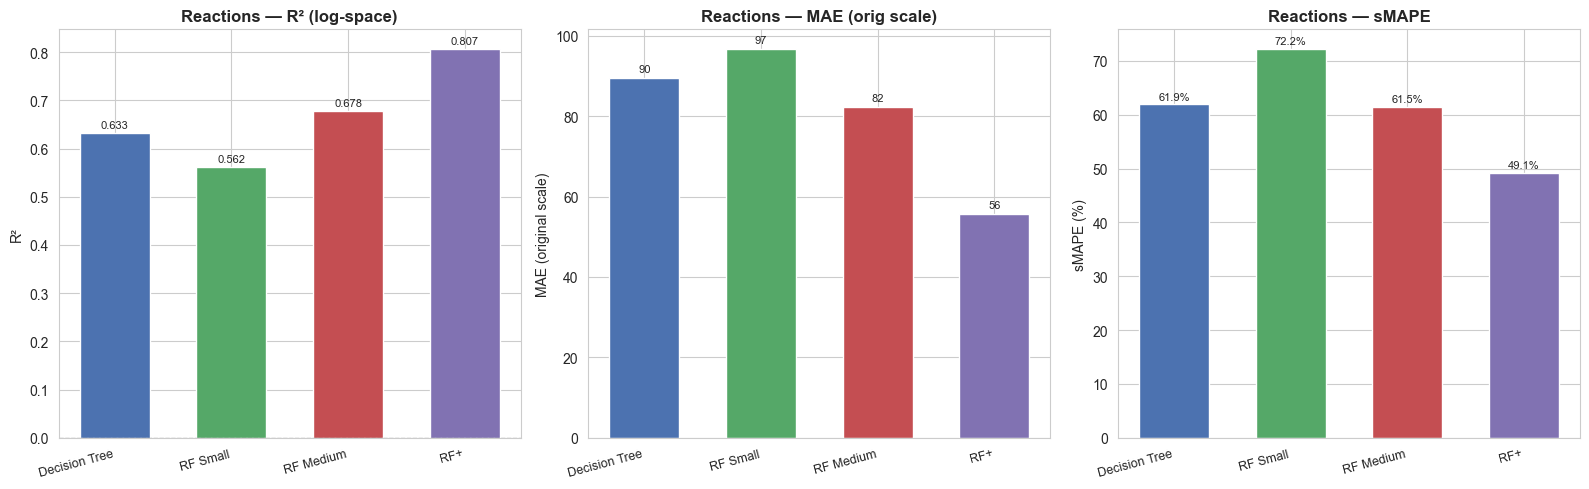

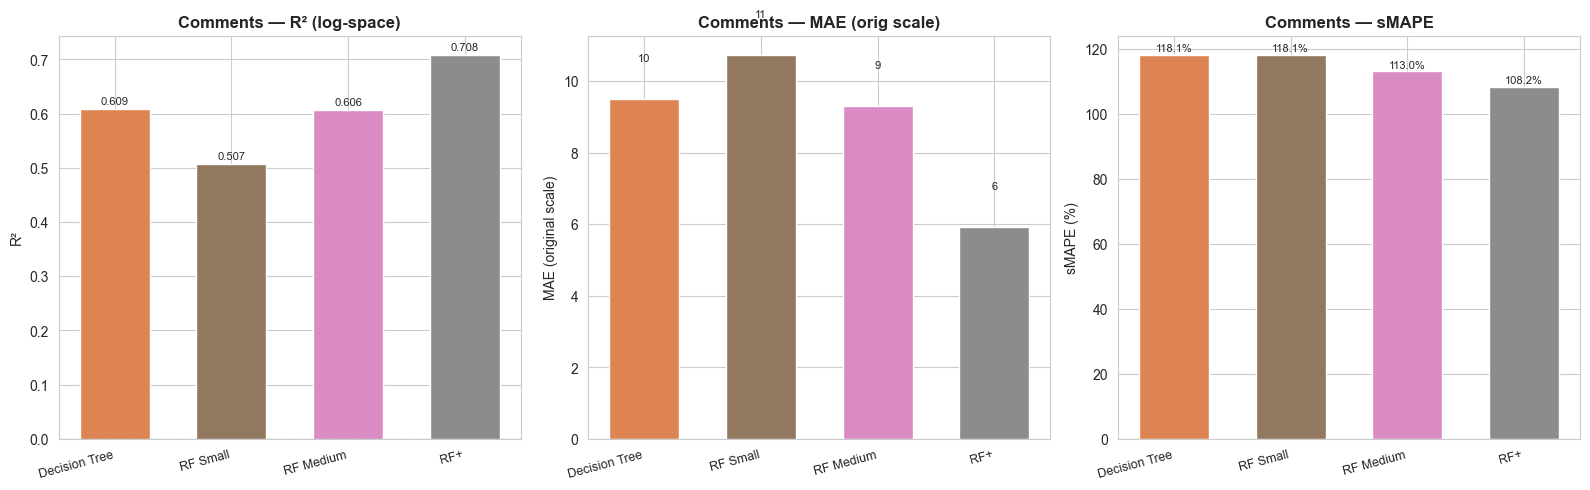

In [ ]:
def plot_comparison(results, target_name, color_palette=None):
    labels = [r['label'].split('(')[0].strip() for r in results]
    log_r2  = [r['log_r2'] for r in results]
    orig_r2 = [r['r2']     for r in results]
    mae     = [r['mae']    for r in results]
    smape_  = [r['smape']  for r in results]

    if color_palette is None:
        color_palette = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    x = np.arange(len(labels))

    bars0 = axes[0].bar(x, log_r2, color=color_palette, edgecolor='white', width=0.6)
    axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axes[0].set_xticks(x); axes[0].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[0].set_ylabel('R²')
    axes[0].set_title(f'{target_name} — R² (log-space)', fontweight='bold')
    for bar, v in zip(bars0, log_r2):
        axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    bars1 = axes[1].bar(x, mae, color=color_palette, edgecolor='white', width=0.6)
    axes[1].set_xticks(x); axes[1].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[1].set_ylabel('MAE (original scale)')
    axes[1].set_title(f'{target_name} — MAE (orig scale)', fontweight='bold')
    for bar, v in zip(bars1, mae):
        axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, f'{v:.0f}', ha='center', va='bottom', fontsize=8)

    bars2 = axes[2].bar(x, smape_, color=color_palette, edgecolor='white', width=0.6)
    axes[2].set_xticks(x); axes[2].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[2].set_ylabel('sMAPE (%)')
    axes[2].set_title(f'{target_name} — sMAPE', fontweight='bold')
    for bar, v in zip(bars2, smape_):
        axes[2].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_comparison(results_reactions, 'Reactions', ['#4C72B0','#55A868','#C44E52','#8172B2'])
plot_comparison(results_comments, 'Comments',  ['#DD8452','#937860','#DA8BC3','#8C8C8C'])

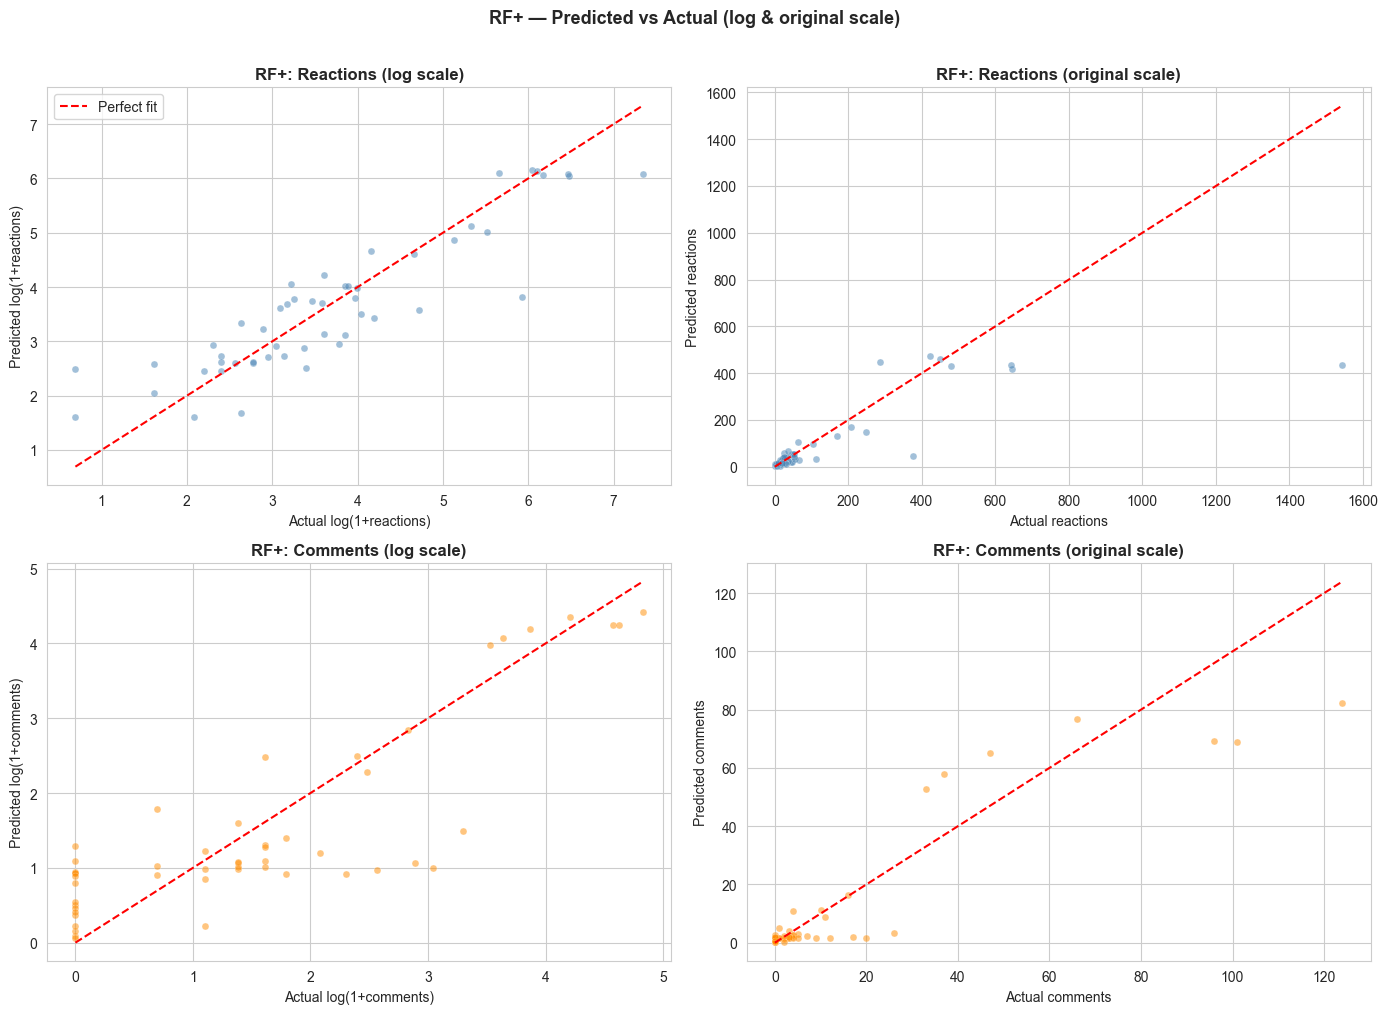

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

y_pred_r_log = rf_plus.predict(X_test_r)
y_pred_c_log = rf_plus_c.predict(X_test_c)
y_pred_r = np.expm1(y_pred_r_log)
y_pred_c = np.expm1(y_pred_c_log)

# Log scale - reactions
axes[0,0].scatter(yr_test, y_pred_r_log, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [min(yr_test.min(), y_pred_r_log.min()), max(yr_test.max(), y_pred_r_log.max())]
axes[0,0].plot(lims, lims, 'r--', lw=1.5, label='Perfect fit')
axes[0,0].set_xlabel('Actual log(1+reactions)'); axes[0,0].set_ylabel('Predicted log(1+reactions)')
axes[0,0].set_title('RF+: Reactions (log scale)', fontweight='bold')
axes[0,0].legend()

# Original scale - reactions
axes[0,1].scatter(yr_test_raw, y_pred_r, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [0, max(yr_test_raw.max(), y_pred_r.max())]
axes[0,1].plot(lims, lims, 'r--', lw=1.5)
axes[0,1].set_xlabel('Actual reactions'); axes[0,1].set_ylabel('Predicted reactions')
axes[0,1].set_title('RF+: Reactions (original scale)', fontweight='bold')

# Log scale - comments
axes[1,0].scatter(yc_test, y_pred_c_log, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [min(yc_test.min(), y_pred_c_log.min()), max(yc_test.max(), y_pred_c_log.max())]
axes[1,0].plot(lims, lims, 'r--', lw=1.5)
axes[1,0].set_xlabel('Actual log(1+comments)'); axes[1,0].set_ylabel('Predicted log(1+comments)')
axes[1,0].set_title('RF+: Comments (log scale)', fontweight='bold')

# Original scale - comments
axes[1,1].scatter(yc_test_raw, y_pred_c, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [0, max(yc_test_raw.max(), y_pred_c.max())]
axes[1,1].plot(lims, lims, 'r--', lw=1.5)
axes[1,1].set_xlabel('Actual comments'); axes[1,1].set_ylabel('Predicted comments')
axes[1,1].set_title('RF+: Comments (original scale)', fontweight='bold')

plt.suptitle('RF+ — Predicted vs Actual (log & original scale)', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Section 7. Feature Importance

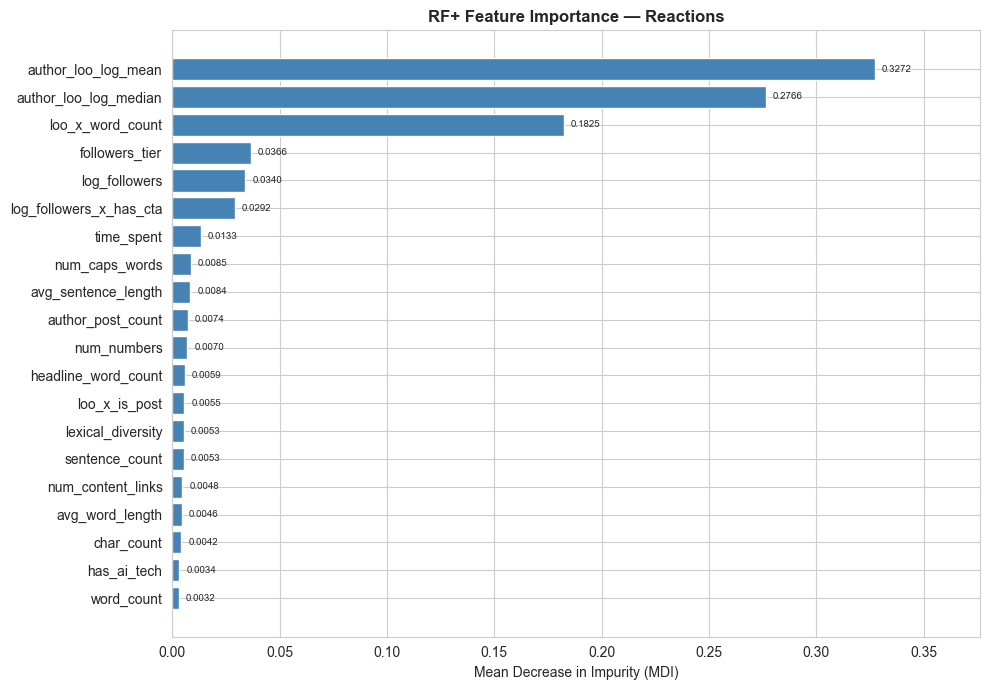

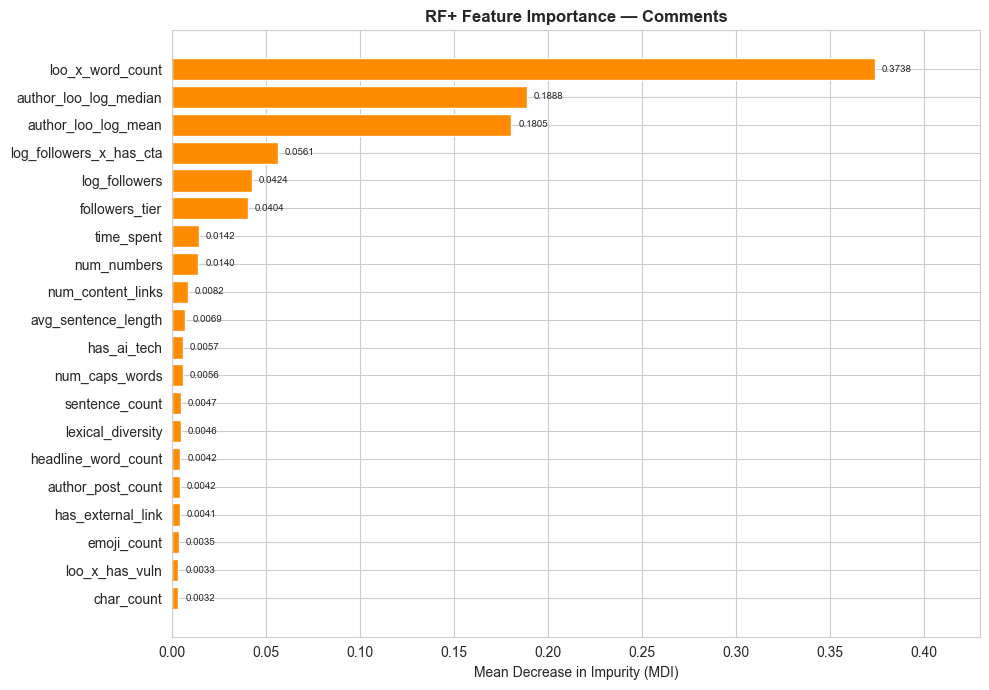

In [ ]:
def plot_importance(model, feature_names, title, color='steelblue', top_n=20):
    imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(10, 7))
    imp_sorted = imp.sort_values()
    bars = ax.barh(imp_sorted.index, imp_sorted.values, color=color, edgecolor='white')
    ax.set_xlabel('Mean Decrease in Impurity (MDI)')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlim(0, imp_sorted.values.max() * 1.15)
    for bar, v in zip(bars, imp_sorted.values):
        ax.text(v + imp_sorted.values.max()*0.01, bar.get_y()+bar.get_height()/2,
                f'{v:.4f}', va='center', fontsize=7)
    plt.tight_layout()
    plt.show()

plot_importance(rf_plus,   feature_names_r, 'RF+ Feature Importance — Reactions', color='steelblue')
plot_importance(rf_plus_c, feature_names_c, 'RF+ Feature Importance — Comments',  color='darkorange')

## Section 8. Decision Tree Visualization

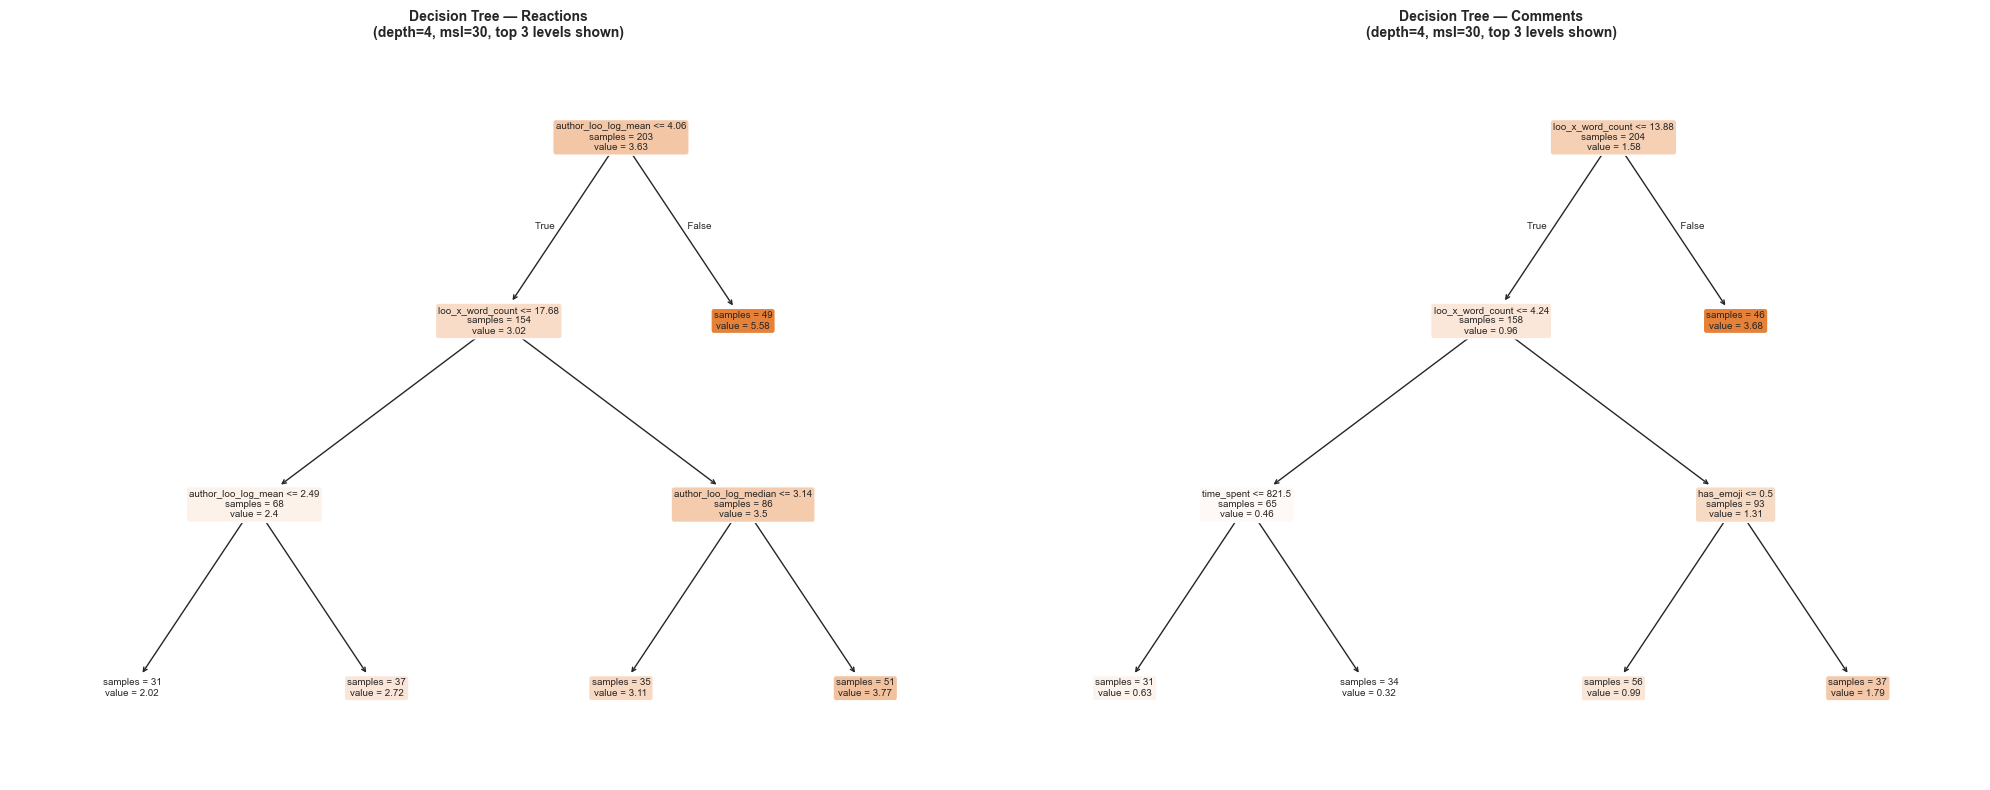

Decision Tree Rules (Reactions, max depth 4):
|--- author_loo_log_mean <= 4.06
|   |--- loo_x_word_count <= 17.68
|   |   |--- author_loo_log_mean <= 2.49
|   |   |   |--- value: [2.02]
|   |   |--- author_loo_log_mean >  2.49
|   |   |   |--- value: [2.72]
|   |--- loo_x_word_count >  17.68
|   |   |--- author_loo_log_median <= 3.14
|   |   |   |--- value: [3.11]
|   |   |--- author_loo_log_median >  3.14
|   |   |   |--- value: [3.77]
|--- author_loo_log_mean >  4.06
|   |--- value: [5.58]



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

plot_tree(dt, feature_names=feature_names_r, ax=axes[0],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[0].set_title('Decision Tree — Reactions\n(depth=4, msl=30, top 3 levels shown)',
                   fontweight='bold', fontsize=10)

plot_tree(dt_c, feature_names=feature_names_c, ax=axes[1],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[1].set_title('Decision Tree — Comments\n(depth=4, msl=30, top 3 levels shown)',
                  fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print('Decision Tree Rules (Reactions, max depth 4):')
print(export_text(dt, feature_names=feature_names_r, max_depth=4))

## Section 9. Results Summary Table

In [ ]:
print('='*80)
print('FINAL RESULTS SUMMARY')
print('='*80)

def summary_df(results):
    rows = []
    for r in results:
        rows.append({
            'Model': r['label'],
            'Log R²': round(r['log_r2'], 4),
            'Log MAE': round(r['log_mae'], 4),
            'MAE (orig)': round(r['mae'], 1),
            'RMSE (orig)': round(r['rmse'], 1),
            'R² (orig)': round(r['r2'], 4),
            'sMAPE (%)': round(r['smape'], 1),
            'MedAE (orig)': round(r['medae'], 1),
            'Spearman ρ': round(r['spearman_rho'], 4),
        })
    return pd.DataFrame(rows).set_index('Model')

print('\nREACTIONS:')
df_r = summary_df(results_reactions)
print(df_r.to_string())

print('\nCOMMENTS:')
df_c = summary_df(results_comments)
print(df_c.to_string())

best_r = df_r['Log R²'].idxmax()
best_c = df_c['Log R²'].idxmax()
print(f'\nBest for reactions: {best_r}  (Log R²={df_r.loc[best_r, "Log R²"]}  Spearman ρ={df_r.loc[best_r, "Spearman ρ"]})')
print(f'Best for comments:  {best_c}  (Log R²={df_c.loc[best_c, "Log R²"]}  Spearman ρ={df_c.loc[best_c, "Spearman ρ"]})')

FINAL RESULTS SUMMARY

REACTIONS:
                                         Log R²  Log MAE  MAE (orig)  RMSE (orig)  R² (orig)  sMAPE (%)  MedAE (orig)  Spearman ρ
Model                                                                                                                            
Decision Tree (depth=4, msl=30)          0.6327   0.6714        89.6        216.9     0.2879       61.9          12.5      0.8280
RF Small (depth=4, msl=30, MAE)          0.5620   0.7916        96.7        243.8     0.1006       72.2          16.6      0.8224
RF Medium (depth=5, msl=20, MAE)         0.6784   0.6554        82.4        223.4     0.2446       61.5          12.8      0.8606
RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)  0.8066   0.4971        55.7        170.9     0.5581       49.1          11.2      0.8853

COMMENTS:
                                         Log R²  Log MAE  MAE (orig)  RMSE (orig)  R² (orig)  sMAPE (%)  MedAE (orig)  Spearman ρ
Model                                        

## Section 10. Predict on New Sample

In [ ]:
def predict_engagement(
    followers=10_000,
    connections=500,
    time_spent=30,
    num_hashtags=3,
    media_type='post',
    content="Excited to share that I've just been promoted to Senior Engineer! This journey has been incredible.",
    headline='Senior Software Engineer',
    num_content_links=0,
):
    """
    Predict reactions and comments for a new LinkedIn post.
    Author baseline always uses the global LOO mean — author identity
    is not available at inference time.
    Each model uses its own LOO stats (reactions-based vs comments-based).
    """
    sample = pd.DataFrame([{
        'followers':     followers,
        'connections':   connections,
        'time_spent':    time_spent,
        'num_hashtags':  num_hashtags,
        'media_type':    media_type,
        'content':       content,
        'headline':      headline,
        'content_links': np.nan if num_content_links == 0 else '; '.join(['http://example.com'] * num_content_links),
        'hashtags':      np.nan,
        'name':          '__unknown__',   # always falls back to global LOO mean
    }])

    # Reactions model — uses reactions LOO stats
    X_new_r = engineer_features(sample, loo_stats_r).fillna(0)
    for col in feature_names_r:
        if col not in X_new_r.columns:
            X_new_r[col] = 0
    X_new_r = X_new_r[feature_names_r]

    # Comments model — uses comments LOO stats
    X_new_c = engineer_features(sample, loo_stats_c).fillna(0)
    for col in feature_names_c:
        if col not in X_new_c.columns:
            X_new_c[col] = 0
    X_new_c = X_new_c[feature_names_c]

    pred_r_log = rf_plus.predict(X_new_r)[0]
    pred_c_log = rf_plus_c.predict(X_new_c)[0]
    pred_reactions = max(0, np.expm1(pred_r_log))
    pred_comments  = max(0, np.expm1(pred_c_log))

    print(f"{followers:,} followers  |  {media_type}  |  {num_hashtags} hashtags")
    print(f"  Predicted reactions: {pred_reactions:.0f}  (log={pred_r_log:.3f})")
    print(f"  Predicted comments:  {pred_comments:.0f}   (log={pred_c_log:.3f})")
    return pred_reactions, pred_comments

# ── Example 1: Large account, personal vulnerability story ────────────────────
print("--- Example 1: Large account, personal story ---")
predict_engagement(
    followers=150_000, num_hashtags=5, media_type='post',
    content='After 10 years I finally failed. And that failure taught me everything. I was scared to share this but here it is...'
)

# ── Example 2: Mid-size account, article ──────────────────────────────────────
print("\n--- Example 2: Mid-size account, article ---")
predict_engagement(
    followers=25_000, num_hashtags=4, media_type='article',
    content='How AI is transforming enterprise software. What every CTO needs to know about machine learning adoption in 2025.'
)

# ── Example 3: Small account, announcement ────────────────────────────────────
print("\n--- Example 3: Small account, announcement post ---")
predict_engagement(
    followers=8_000, num_hashtags=2, media_type='post',
    content="Excited to share that I've just been promoted to Senior Engineer! This journey has been incredible."
)

--- Example 1: Large account, personal story ---
150,000 followers  |  post  |  5 hashtags
  Predicted reactions: 24  (log=3.237)
  Predicted comments:  3   (log=1.328)

--- Example 2: Mid-size account, article ---
25,000 followers  |  article  |  4 hashtags
  Predicted reactions: 24  (log=3.213)
  Predicted comments:  2   (log=1.171)

--- Example 3: Small account, announcement post ---
8,000 followers  |  post  |  2 hashtags
  Predicted reactions: 24  (log=3.200)
  Predicted comments:  2   (log=1.170)


(23.52769203679151, 2.2207166902879067)

In [9]:
def compute_loo_author_stats(df_):
    """
    Compute leave-one-out per-author engagement statistics on log scale.
    For each post i by author A:
        loo_log_mean[i] = mean(log(1+reactions)) of all OTHER posts by A
    This is a valid feature — it uses only historical posts, never the current one.
    Authors with only 1 post after filtering fall back to the global mean.
    """
    df_ = df_.copy()
    df_['log_reactions'] = np.log1p(df_['reactions'])
    global_log_mean   = df_['log_reactions'].mean()
    global_log_median = df_['log_reactions'].median()

    loo_log_mean   = {}
    loo_log_median = {}
    post_count     = {}

    for author, grp in df_.groupby('name'):
        post_count[author] = len(grp)
        vals = grp['log_reactions'].values
        if len(vals) < 2:
            loo_log_mean[author]   = global_log_mean
            loo_log_median[author] = global_log_median
        else:
            # Per-row LOO means; store the author-level average for simplicity
            # (used in feature engineering — same value for all rows of this author)
            row_means   = [np.delete(vals, i).mean()   for i in range(len(vals))]
            row_medians = [np.median(np.delete(vals, i)) for i in range(len(vals))]
            loo_log_mean[author]   = np.mean(row_means)
            loo_log_median[author] = np.mean(row_medians)

    return {
        'loo_log_mean':    loo_log_mean,
        'loo_log_median':  loo_log_median,
        'post_count':      post_count,
        'global_log_mean': global_log_mean,
        'global_log_median': global_log_median,
    }

loo_stats = compute_loo_author_stats(df)

print("LOO author baseline computed.")
print(f"  Global log-mean: {loo_stats['global_log_mean']:.4f}")
print(f"  Authors covered: {len(loo_stats['loo_log_mean'])}")
print(f"\nSample LOO means (log scale):")
for author, val in list(loo_stats['loo_log_mean'].items())[:8]:
    cnt = loo_stats['post_count'][author]
    raw_equiv = np.expm1(val)
    print(f"  {author[:35]:35s}  posts={cnt}  loo_log_mean={val:.3f}  (≈{raw_equiv:.0f} reactions)")

LOO author baseline computed.
  Global log-mean: 3.6481
  Authors covered: 40

Sample LOO means (log scale):
  abidalee                             posts=10  loo_log_mean=2.553  (≈12 reactions)
  alexchriss                           posts=9  loo_log_mean=3.843  (≈46 reactions)
  amitrawal-ai                         posts=10  loo_log_mean=3.850  (≈46 reactions)
  andressantana                        posts=2  loo_log_mean=3.213  (≈24 reactions)
  ankit-pangasa                        posts=6  loo_log_mean=5.077  (≈159 reactions)
  ariadi                               posts=7  loo_log_mean=2.841  (≈16 reactions)
  arundhati-banerjee-130912a0          posts=11  loo_log_mean=3.125  (≈22 reactions)
  avr27                                posts=5  loo_log_mean=2.976  (≈19 reactions)


## Section 2. Feature Engineering

In [10]:
def count_emojis(text):
    if not isinstance(text, str):
        return 0
    count = 0
    for char in text:
        if ord(char) >= 0x1F300:
            count += 1
    return count

EMOJI_PATTERN = re.compile(
    "[\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F9FF"
    "\U00002600-\U000027BF"
    "\U0001FA00-\U0001FA9F]+",
    flags=re.UNICODE
)

def count_emojis_v2(text):
    if not isinstance(text, str):
        return 0
    return len(EMOJI_PATTERN.findall(text))

def get_sentiment(text):
    if not TEXTBLOB_AVAILABLE or not isinstance(text, str):
        return 0.0, 0.5
    blob = TextBlob(text[:2000])
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def engineer_features(df_, loo_stats):
    """Build feature matrix.
    loo_stats: dict from compute_loo_author_stats — no leakage, uses leave-one-out.
    """
    feats = pd.DataFrame(index=df_.index)

    # ── Author-level features ──────────────────────────────────────────────────
    log_f = np.log1p(df_['followers'].fillna(0))
    feats['log_followers'] = log_f

    # Explicit follower tier (0=micro … 4=mega)
    feats['followers_tier'] = pd.cut(
        df_['followers'].fillna(0),
        bins=[0, 5_000, 30_000, 150_000, 500_000, float('inf')],
        labels=[0, 1, 2, 3, 4]
    ).astype(float)

    feats['time_spent'] = df_['time_spent'].fillna(0)

    # ── LOO author baseline (the strongest single feature) ────────────────────
    feats['author_loo_log_mean']   = df_['name'].map(loo_stats['loo_log_mean']).fillna(loo_stats['global_log_mean'])
    feats['author_loo_log_median'] = df_['name'].map(loo_stats['loo_log_median']).fillna(loo_stats['global_log_median'])
    feats['author_post_count']     = df_['name'].map(loo_stats['post_count']).fillna(1)

    # ── Media type ────────────────────────────────────────────────────────────
    mt = df_['media_type'].fillna('post')
    feats['is_post']    = (mt == 'post').astype(int)
    feats['is_article'] = (mt == 'article').astype(int)
    feats['is_repost']  = (mt == 'repost').astype(int)

    # ── Hashtags ──────────────────────────────────────────────────────────────
    feats['num_hashtags']   = df_['num_hashtags'].fillna(0)
    feats['has_hashtags']   = (feats['num_hashtags'] > 0).astype(int)
    feats['hashtag_bucket'] = pd.cut(
        feats['num_hashtags'], bins=[-1, 0, 2, 5, 10, 100], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    # ── Content links ─────────────────────────────────────────────────────────
    def count_links(x):
        if not isinstance(x, str): return 0
        return len([l for l in x.split(';') if l.strip()])
    feats['num_content_links'] = df_['content_links'].apply(count_links)
    feats['has_external_link'] = (feats['num_content_links'] > 0).astype(int)

    # ── Content text features ─────────────────────────────────────────────────
    content = df_['content'].fillna('')

    feats['char_count']      = content.str.len()
    feats['word_count']      = content.apply(lambda x: len(x.split()))
    feats['sentence_count']  = content.apply(lambda x: max(1, len(re.split(r'[.!?]+', x))))
    feats['line_count']      = content.apply(lambda x: max(1, len(x.strip().split('\n'))))
    feats['avg_word_length'] = content.apply(
        lambda x: np.mean([len(w) for w in x.split()]) if x.split() else 0
    )
    feats['avg_sentence_length'] = feats['word_count'] / feats['sentence_count']
    feats['post_density']  = feats['word_count'] / feats['line_count']
    feats['is_long_form']  = (feats['word_count'] > 500).astype(int)

    feats['first_line_words'] = content.apply(
        lambda x: len(x.strip().split('\n')[0].split())
    )
    feats['first_line_short'] = (feats['first_line_words'] <= 12).astype(int)

    feats['num_exclamations'] = content.str.count('!')
    feats['num_questions']    = content.str.count(r'\?')
    feats['has_exclamation']  = (feats['num_exclamations'] > 0).astype(int)
    feats['has_question']     = (feats['num_questions'] > 0).astype(int)
    feats['num_caps_words']   = content.apply(
        lambda x: sum(1 for w in x.split() if len(w) > 1 and w.isupper())
    )
    feats['num_numbers'] = content.apply(lambda x: len(re.findall(r'\b\d+\b', x)))
    feats['has_numbers'] = (feats['num_numbers'] > 0).astype(int)

    feats['bullet_count'] = content.apply(
        lambda x: sum(1 for line in x.split('\n') if re.match(r'^\s*[-\u2022*]\s', line))
    )
    feats['has_bullets']       = (feats['bullet_count'] > 0).astype(int)
    feats['has_numbered_list'] = content.apply(
        lambda x: int(bool(re.search(r'^\s*\d+[.)]\s', x, re.MULTILINE)))
    )
    feats['mention_count']  = content.str.count(r'@\w+')
    feats['url_in_content'] = content.str.count(r'https?://\S+')

    feats['emoji_count'] = content.apply(count_emojis_v2)
    feats['has_emoji']   = (feats['emoji_count'] > 0).astype(int)

    feats['lexical_diversity'] = content.apply(
        lambda x: len(set(x.lower().split())) / max(1, len(x.split()))
    )

    feats['length_bucket'] = pd.cut(
        feats['word_count'], bins=[0, 50, 150, 300, 500, 10000], labels=[0, 1, 2, 3, 4]
    ).astype(float)

    feats['has_personal_hook']  = content.apply(
        lambda x: int(bool(re.match(r'^(I |After |When |Today |Yesterday |In \d)', x.strip())))
    )
    feats['starts_with_number'] = content.apply(
        lambda x: int(bool(re.match(r'^\s*\d', x.strip())))
    )
    feats['has_announcement'] = content.apply(
        lambda x: int(bool(re.search(r'\b(excited|thrilled|proud|happy|delighted|announcing|announced)\b', x, re.I)))
    )
    feats['has_question_hook'] = content.apply(
        lambda x: int(x.strip().startswith(('What ', 'How ', 'Why ', 'Who ', 'Is ', 'Are ', 'Do ', 'Can ')))
    )
    feats['has_career_content'] = content.apply(
        lambda x: int(bool(re.search(r'\b(job|career|hired|fired|role|position|company|startup|founder|ceo|promotion)\b', x, re.I)))
    )
    feats['has_vulnerability'] = content.apply(
        lambda x: int(bool(re.search(r'\b(failed|failure|rejected|rejection|scared|afraid|mistake|wrong|sorry|regret)\b', x, re.I)))
    )
    feats['has_ai_tech'] = content.apply(
        lambda x: int(bool(re.search(r'\b(AI|GPT|LLM|machine learning|deep learning|neural|ChatGPT|artificial intelligence)\b', x, re.I)))
    )
    feats['has_cta'] = content.apply(
        lambda x: int(bool(re.search(r'\b(share|comment|follow|like|repost|what do you think|thoughts\?|agree\?)\b', x, re.I)))
    )
    feats['personal_story_score'] = (
        feats['has_personal_hook'] +
        feats['has_vulnerability'] +
        feats['has_announcement']
    )

    headline = df_['headline'].fillna('')
    feats['headline_word_count'] = headline.apply(lambda x: len(x.split()))
    feats['headline_has_emoji']  = headline.apply(count_emojis_v2).apply(lambda x: int(x > 0))

    if TEXTBLOB_AVAILABLE:
        print("  Computing sentiment (TextBlob)...")
        sentiments = content.apply(get_sentiment)
        feats['sentiment_polarity']    = sentiments.apply(lambda x: x[0])
        feats['sentiment_subjectivity'] = sentiments.apply(lambda x: x[1])
    else:
        feats['sentiment_polarity']    = 0.0
        feats['sentiment_subjectivity'] = 0.5

    # ── Interaction features ───────────────────────────────────────────────────
    feats['log_followers_x_is_post']  = log_f * feats['is_post']
    feats['log_followers_x_has_vuln'] = log_f * feats['has_vulnerability']
    feats['log_followers_x_has_cta']  = log_f * feats['has_cta']
    feats['log_followers_x_personal'] = log_f * feats['personal_story_score']

    # LOO baseline × content (captures author-specific content preferences)
    loo_mean = feats['author_loo_log_mean']
    feats['loo_x_is_post']    = loo_mean * feats['is_post']
    feats['loo_x_has_vuln']   = loo_mean * feats['has_vulnerability']
    feats['loo_x_word_count'] = loo_mean * np.log1p(feats['word_count'])

    return feats

print("Feature engineering function defined  (LOO-aware).")

Feature engineering function defined  (LOO-aware).


In [11]:
print('Engineering features on filtered dataset...')
X_raw = engineer_features(df, loo_stats).fillna(0)
print(f'\nFeature matrix shape: {X_raw.shape}')
print(f'\nNull counts after fillna: {X_raw.isnull().sum().sum()} (should be 0)')

# Quick sanity: LOO mean should be strongly correlated with target
import scipy.stats as stats
log_y = np.log1p(df['reactions'].values)
r_loo, _ = stats.pearsonr(X_raw['author_loo_log_mean'], log_y)
r_lf,  _ = stats.pearsonr(X_raw['log_followers'],       log_y)
print(f'\nCorr with log(reactions):')
print(f'  author_loo_log_mean:  {r_loo:.4f}  ← strongest feature')
print(f'  log_followers:        {r_lf:.4f}')

Engineering features on filtered dataset...

Feature matrix shape: (254, 60)

Null counts after fillna: 0 (should be 0)

Corr with log(reactions):
  author_loo_log_mean:  0.8646  ← strongest feature
  log_followers:        0.6196


In [24]:
df.shape

(254, 19)

In [12]:
# Target log transform — on the filtered dataset
y_reactions_raw = df['reactions'].values
y_comments_raw  = df['comments'].values

y_reactions_log = np.log1p(y_reactions_raw)
y_comments_log  = np.log1p(y_comments_raw)

print(f'Filtered dataset: {len(df)} rows')
print('\nTarget summary (original scale):')
print(f'  Reactions — mean: {y_reactions_raw.mean():.0f}  median: {np.median(y_reactions_raw):.0f}  max: {y_reactions_raw.max()}')
print(f'  Comments  — mean: {y_comments_raw.mean():.0f}  median: {np.median(y_comments_raw):.0f}  max: {y_comments_raw.max()}')

print('\nTarget summary (log scale):')
print(f'  log(1+reactions) — mean: {y_reactions_log.mean():.3f}  std: {y_reactions_log.std():.3f}')
print(f'  log(1+comments)  — mean: {y_comments_log.mean():.3f}  std: {y_comments_log.std():.3f}')

Filtered dataset: 254 rows

Target summary (original scale):
  Reactions — mean: 126  median: 31  max: 2668
  Comments  — mean: 17  median: 3  max: 312

Target summary (log scale):
  log(1+reactions) — mean: 3.648  std: 1.513
  log(1+comments)  — mean: 1.612  std: 1.485


In [13]:
feature_names = X_raw.columns.tolist()

# Stratified split by follower tier so each tier is proportionally
# represented in both train and test (avoids test set dominated by one tier)
tier_col = X_raw['followers_tier'].fillna(0).astype(int)

X_train, X_test, \
yr_train, yr_test, \
yc_train, yc_test, \
yr_train_raw, yr_test_raw, \
yc_train_raw, yc_test_raw = train_test_split(
    X_raw.values,
    y_reactions_log, y_comments_log,
    y_reactions_raw, y_comments_raw,
    test_size=0.2, random_state=RANDOM_STATE,
    stratify=tier_col         # <-- keep tier distribution balanced
)

print(f'Train: {X_train.shape[0]} samples  |  Test: {X_test.shape[0]} samples')
print(f'Features: {X_train.shape[1]}')

# Verify tier distribution in train vs test
tier_idx = feature_names.index('followers_tier')
train_tiers = X_train[:, tier_idx]
test_tiers  = X_test[:,  tier_idx]
tier_labels = ['micro(<5k)', 'small(5-30k)', 'mid(30-150k)', 'large(150-500k)', 'mega(>500k)']
print('\nFollower tier split (train | test):')
for t, lbl in enumerate(tier_labels):
    tr = (train_tiers == t).sum()
    te = (test_tiers  == t).sum()
    print(f'  {lbl:18s}  train={tr:3d} ({tr/len(train_tiers)*100:.0f}%)  test={te:2d} ({te/len(test_tiers)*100:.0f}%)')

Train: 203 samples  |  Test: 51 samples
Features: 60

Follower tier split (train | test):
  micro(<5k)          train= 28 (14%)  test= 7 (14%)
  small(5-30k)        train= 73 (36%)  test=19 (37%)
  mid(30-150k)        train= 53 (26%)  test=13 (25%)
  large(150-500k)     train= 22 (11%)  test= 5 (10%)
  mega(>500k)         train= 27 (13%)  test= 7 (14%)


## Section 3. Evaluation Helpers

In [14]:
def smape(y_true, y_pred):
    """Symmetric MAPE (handles zeros)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1, denom)
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

def evaluate(y_true_log, y_pred_log, y_true_raw, label=''):
    """Evaluate in both log-space and original-space."""
    # Back-transform
    y_pred_raw = np.expm1(y_pred_log)
    y_pred_raw = np.maximum(y_pred_raw, 0)  # clip negatives

    return {
        'label': label,
        # Log-space
        'log_mae':  mean_absolute_error(y_true_log, y_pred_log),
        'log_r2':   r2_score(y_true_log, y_pred_log),
        # Original-space
        'mae':  mean_absolute_error(y_true_raw, y_pred_raw),
        'rmse': np.sqrt(mean_squared_error(y_true_raw, y_pred_raw)),
        'r2':   r2_score(y_true_raw, y_pred_raw),
        'smape': smape(y_true_raw, y_pred_raw),
        'medae': np.median(np.abs(y_true_raw - y_pred_raw)),
    }

def print_metrics(m):
    print(f"  [{m['label']}]")
    print(f"    Log-space  → MAE: {m['log_mae']:.4f}  R²: {m['log_r2']:.4f}")
    print(f"    Orig-space → MAE: {m['mae']:.1f}  RMSE: {m['rmse']:.1f}  R²: {m['r2']:.4f}  sMAPE: {m['smape']:.1f}%  MedAE: {m['medae']:.1f}")

print('Evaluation helpers defined.')

Evaluation helpers defined.


## Section 4. Model Training

## Model Design Rationale

| Model | max_depth | min_samples_leaf | max_features | criterion | Notes |
|-------|-----------|-----------------|--------------|-----------|-------|
| Decision Tree | 4 | 30 | — | squared_error | Interpretable baseline |
| RF Small | 4 | 30 | sqrt | absolute_error | High regularisation |
| RF Medium | 5 | 20 | sqrt | absolute_error | Balanced |
| RF+ | 6 | 10 | 0.5 | absolute_error | MAE + OOB + more features per split |

All models trained on **log(1+y)** targets.  
Predictions back-transformed with **exp(ŷ) − 1**.  
Split is **stratified by follower tier** so every tier appears proportionally in both sets.

In [15]:
print('='*65)
print('REACTIONS PREDICTION  (trained on log(1+reactions))')
print('='*65)

results_reactions = []
models_reactions  = {}

# --- 1. Decision Tree (baseline, interpretable) ---
dt = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt.fit(X_train, yr_train)
models_reactions['Decision Tree'] = dt
m = evaluate(yr_test, dt.predict(X_test), yr_test_raw, 'Decision Tree (depth=4, msl=30)')
results_reactions.append(m)
print_metrics(m)

# --- 2. RF Small (high regularisation) ---
rf_small = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small.fit(X_train, yr_train)
models_reactions['RF Small'] = rf_small
m = evaluate(yr_test, rf_small.predict(X_test), yr_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 3. RF Medium ---
rf_med = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med.fit(X_train, yr_train)
models_reactions['RF Medium'] = rf_med
m = evaluate(yr_test, rf_med.predict(X_test), yr_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_reactions.append(m)
print_metrics(m)

# --- 4. RF+ (best config) ---
# max_features=0.5 (vs sqrt≈0.16) gives key features like log_followers
# more chances to appear at each split — critical for a follower-dominated signal
rf_plus = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus.fit(X_train, yr_train)
models_reactions['RF+'] = rf_plus
m = evaluate(yr_test, rf_plus.predict(X_test), yr_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_reactions.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus.oob_score_:.4f}')

REACTIONS PREDICTION  (trained on log(1+reactions))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.6714  R²: 0.6327
    Orig-space → MAE: 89.6  RMSE: 216.9  R²: 0.2879  sMAPE: 61.9%  MedAE: 12.5
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.7916  R²: 0.5620
    Orig-space → MAE: 96.7  RMSE: 243.8  R²: 0.1006  sMAPE: 72.2%  MedAE: 16.6
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.6554  R²: 0.6784
    Orig-space → MAE: 82.4  RMSE: 223.4  R²: 0.2446  sMAPE: 61.5%  MedAE: 12.8
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.4971  R²: 0.8066
    Orig-space → MAE: 55.7  RMSE: 170.9  R²: 0.5581  sMAPE: 49.1%  MedAE: 11.2

  RF+ OOB R² (train): 0.6786


In [16]:
print('='*65)
print('COMMENTS PREDICTION  (trained on log(1+comments))')
print('='*65)

results_comments = []
models_comments  = {}

dt_c = DecisionTreeRegressor(
    max_depth=4,
    min_samples_leaf=30,
    criterion='squared_error',
    random_state=RANDOM_STATE
)
dt_c.fit(X_train, yc_train)
models_comments['Decision Tree'] = dt_c
m = evaluate(yc_test, dt_c.predict(X_test), yc_test_raw, 'Decision Tree (depth=4, msl=30)')
results_comments.append(m)
print_metrics(m)

rf_small_c = RandomForestRegressor(
    n_estimators=300,
    max_depth=4,
    min_samples_leaf=30,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_small_c.fit(X_train, yc_train)
models_comments['RF Small'] = rf_small_c
m = evaluate(yc_test, rf_small_c.predict(X_test), yc_test_raw, 'RF Small (depth=4, msl=30, MAE)')
results_comments.append(m)
print_metrics(m)

rf_med_c = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_leaf=20,
    max_features='sqrt',
    criterion='absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_med_c.fit(X_train, yc_train)
models_comments['RF Medium'] = rf_med_c
m = evaluate(yc_test, rf_med_c.predict(X_test), yc_test_raw, 'RF Medium (depth=5, msl=20, MAE)')
results_comments.append(m)
print_metrics(m)

rf_plus_c = RandomForestRegressor(
    n_estimators=800,
    max_depth=6,
    min_samples_leaf=10,
    max_features=0.5,
    criterion='absolute_error',
    bootstrap=True,
    oob_score=True,
    min_impurity_decrease=0.0001,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_plus_c.fit(X_train, yc_train)
models_comments['RF+'] = rf_plus_c
m = evaluate(yc_test, rf_plus_c.predict(X_test), yc_test_raw, 'RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)')
results_comments.append(m)
print_metrics(m)
print(f'\n  RF+ OOB R² (train): {rf_plus_c.oob_score_:.4f}')

COMMENTS PREDICTION  (trained on log(1+comments))
  [Decision Tree (depth=4, msl=30)]
    Log-space  → MAE: 0.7664  R²: 0.5137
    Orig-space → MAE: 8.9  RMSE: 17.4  R²: 0.5137  sMAPE: 107.7%  MedAE: 3.0
  [RF Small (depth=4, msl=30, MAE)]
    Log-space  → MAE: 0.8050  R²: 0.5021
    Orig-space → MAE: 10.0  RMSE: 23.2  R²: 0.1346  sMAPE: 110.6%  MedAE: 1.8
  [RF Medium (depth=5, msl=20, MAE)]
    Log-space  → MAE: 0.6944  R²: 0.6185
    Orig-space → MAE: 8.5  RMSE: 20.9  R²: 0.2971  sMAPE: 104.6%  MedAE: 1.5
  [RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)]
    Log-space  → MAE: 0.6207  R²: 0.6707
    Orig-space → MAE: 7.7  RMSE: 15.6  R²: 0.6100  sMAPE: 105.2%  MedAE: 1.7

  RF+ OOB R² (train): 0.5742


## Section 5. Cross-Validation

In [17]:
print('5-Fold Cross-Validation on RF+ (log-space R²)')
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_r = cross_val_score(rf_plus,   X_raw.values, y_reactions_log, cv=kf, scoring='r2', n_jobs=-1)
cv_c = cross_val_score(rf_plus_c, X_raw.values, y_comments_log,  cv=kf, scoring='r2', n_jobs=-1)

print(f'\nReactions  RF+ CV R²: {cv_r}  →  mean={cv_r.mean():.4f} ± {cv_r.std():.4f}')
print(f'Comments   RF+ CV R²: {cv_c}  →  mean={cv_c.mean():.4f} ± {cv_c.std():.4f}')

5-Fold Cross-Validation on RF+ (log-space R²)

Reactions  RF+ CV R²: [0.78579546 0.63019989 0.59913872 0.78335333 0.72680424]  →  mean=0.7051 ± 0.0774
Comments   RF+ CV R²: [0.73418466 0.58092617 0.49549722 0.54300756 0.69502272]  →  mean=0.6097 ± 0.0907


## Section 6. Model Comparison Visualizations

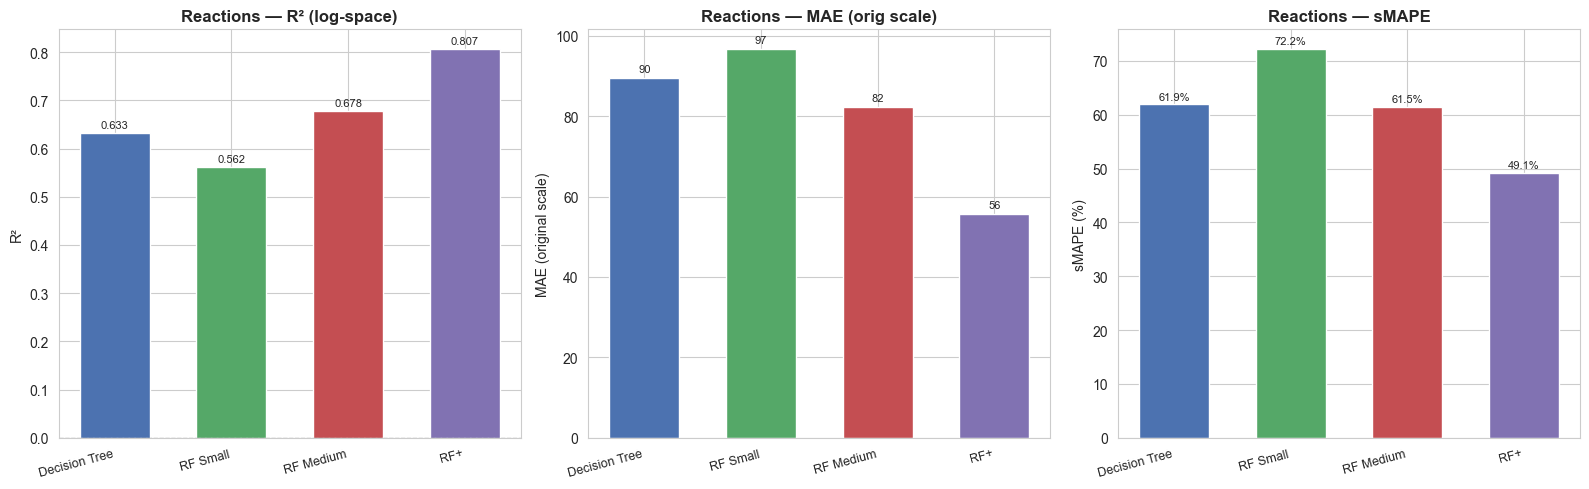

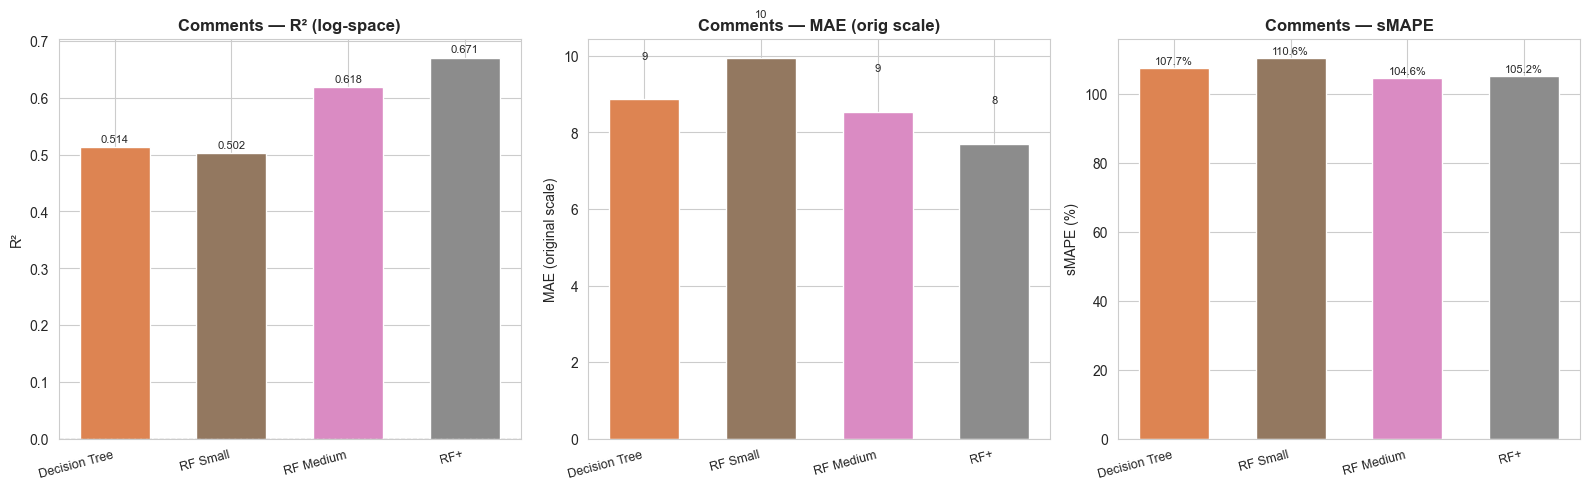

In [18]:
def plot_comparison(results, target_name, color_palette=None):
    labels = [r['label'].split('(')[0].strip() for r in results]
    log_r2  = [r['log_r2'] for r in results]
    orig_r2 = [r['r2']     for r in results]
    mae     = [r['mae']    for r in results]
    smape_  = [r['smape']  for r in results]

    if color_palette is None:
        color_palette = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    x = np.arange(len(labels))

    bars0 = axes[0].bar(x, log_r2, color=color_palette, edgecolor='white', width=0.6)
    axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axes[0].set_xticks(x); axes[0].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[0].set_ylabel('R²')
    axes[0].set_title(f'{target_name} — R² (log-space)', fontweight='bold')
    for bar, v in zip(bars0, log_r2):
        axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    bars1 = axes[1].bar(x, mae, color=color_palette, edgecolor='white', width=0.6)
    axes[1].set_xticks(x); axes[1].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[1].set_ylabel('MAE (original scale)')
    axes[1].set_title(f'{target_name} — MAE (orig scale)', fontweight='bold')
    for bar, v in zip(bars1, mae):
        axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, f'{v:.0f}', ha='center', va='bottom', fontsize=8)

    bars2 = axes[2].bar(x, smape_, color=color_palette, edgecolor='white', width=0.6)
    axes[2].set_xticks(x); axes[2].set_xticklabels(labels, rotation=15, ha='right', fontsize=9)
    axes[2].set_ylabel('sMAPE (%)')
    axes[2].set_title(f'{target_name} — sMAPE', fontweight='bold')
    for bar, v in zip(bars2, smape_):
        axes[2].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f'{v:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_comparison(results_reactions, 'Reactions', ['#4C72B0','#55A868','#C44E52','#8172B2'])
plot_comparison(results_comments, 'Comments',  ['#DD8452','#937860','#DA8BC3','#8C8C8C'])

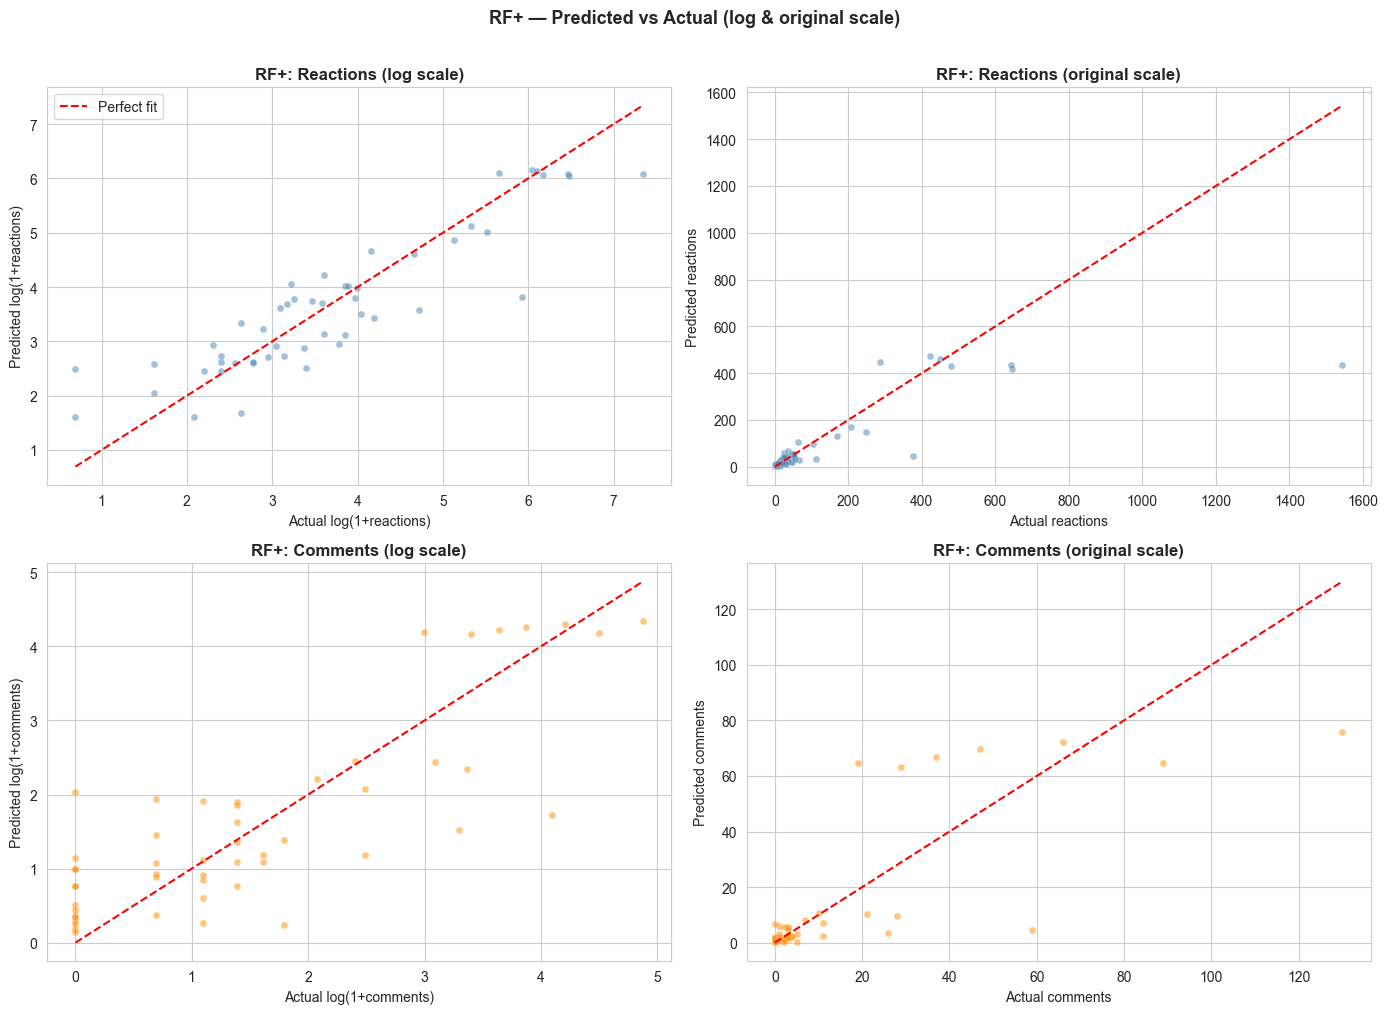

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

best_model_r = rf_plus
best_model_c = rf_plus_c

y_pred_r_log = best_model_r.predict(X_test)
y_pred_c_log = best_model_c.predict(X_test)
y_pred_r = np.expm1(y_pred_r_log)
y_pred_c = np.expm1(y_pred_c_log)

# Log scale - reactions
axes[0,0].scatter(yr_test, y_pred_r_log, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [min(yr_test.min(), y_pred_r_log.min()), max(yr_test.max(), y_pred_r_log.max())]
axes[0,0].plot(lims, lims, 'r--', lw=1.5, label='Perfect fit')
axes[0,0].set_xlabel('Actual log(1+reactions)'); axes[0,0].set_ylabel('Predicted log(1+reactions)')
axes[0,0].set_title('RF+: Reactions (log scale)', fontweight='bold')
axes[0,0].legend()

# Original scale - reactions
axes[0,1].scatter(yr_test_raw, y_pred_r, alpha=0.5, s=25, color='steelblue', edgecolors='white', linewidths=0.3)
lims = [0, max(yr_test_raw.max(), y_pred_r.max())]
axes[0,1].plot(lims, lims, 'r--', lw=1.5)
axes[0,1].set_xlabel('Actual reactions'); axes[0,1].set_ylabel('Predicted reactions')
axes[0,1].set_title('RF+: Reactions (original scale)', fontweight='bold')

# Log scale - comments
axes[1,0].scatter(yc_test, y_pred_c_log, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [min(yc_test.min(), y_pred_c_log.min()), max(yc_test.max(), y_pred_c_log.max())]
axes[1,0].plot(lims, lims, 'r--', lw=1.5)
axes[1,0].set_xlabel('Actual log(1+comments)'); axes[1,0].set_ylabel('Predicted log(1+comments)')
axes[1,0].set_title('RF+: Comments (log scale)', fontweight='bold')

# Original scale - comments
axes[1,1].scatter(yc_test_raw, y_pred_c, alpha=0.5, s=25, color='darkorange', edgecolors='white', linewidths=0.3)
lims = [0, max(yc_test_raw.max(), y_pred_c.max())]
axes[1,1].plot(lims, lims, 'r--', lw=1.5)
axes[1,1].set_xlabel('Actual comments'); axes[1,1].set_ylabel('Predicted comments')
axes[1,1].set_title('RF+: Comments (original scale)', fontweight='bold')

plt.suptitle('RF+ — Predicted vs Actual (log & original scale)', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Section 7. Feature Importance

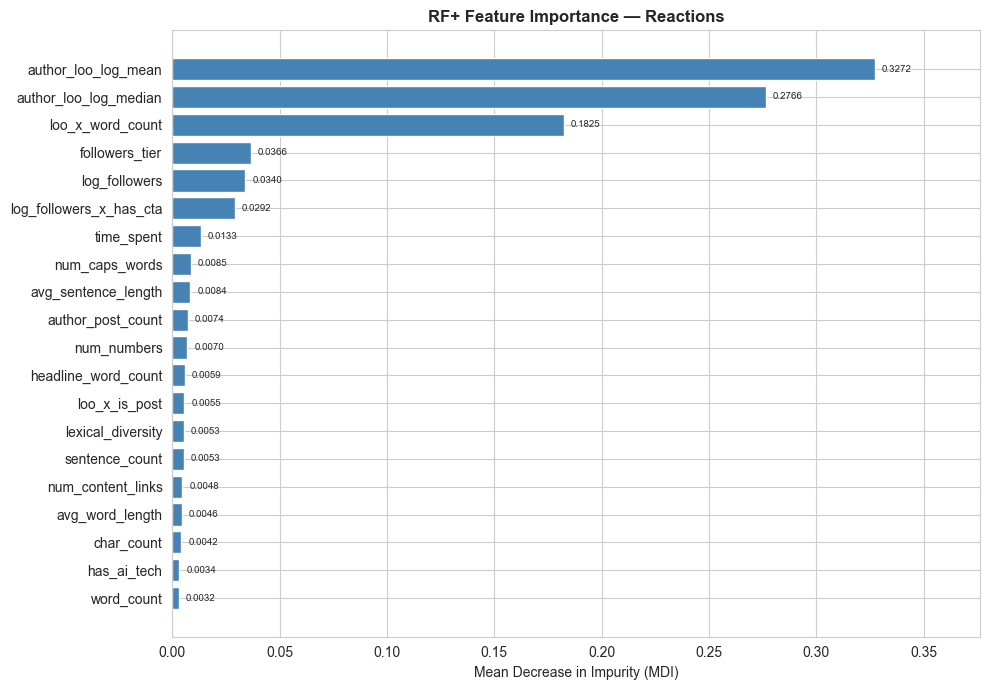

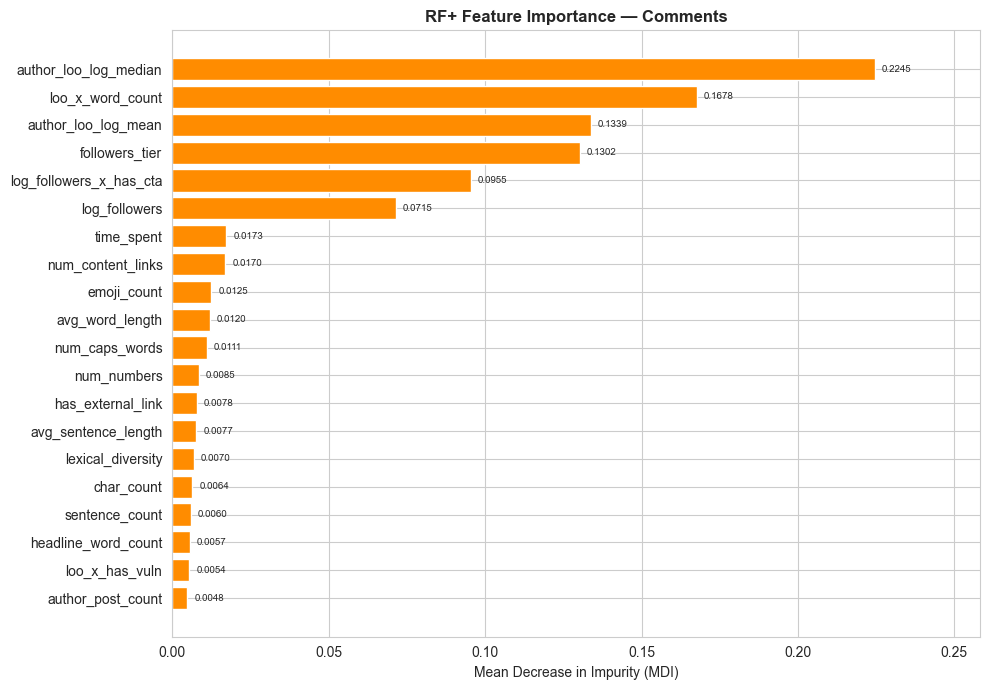

In [20]:
def plot_importance(model, feature_names, title, color='steelblue', top_n=20):
    imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=(10, 7))
    imp_sorted = imp.sort_values()
    bars = ax.barh(imp_sorted.index, imp_sorted.values, color=color, edgecolor='white')
    ax.set_xlabel('Mean Decrease in Impurity (MDI)')
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlim(0, imp_sorted.values.max() * 1.15)
    for bar, v in zip(bars, imp_sorted.values):
        ax.text(v + imp_sorted.values.max()*0.01, bar.get_y()+bar.get_height()/2,
                f'{v:.4f}', va='center', fontsize=7)
    plt.tight_layout()
    plt.show()

plot_importance(rf_plus,   feature_names, 'RF+ Feature Importance — Reactions', color='steelblue')
plot_importance(rf_plus_c, feature_names, 'RF+ Feature Importance — Comments',  color='darkorange')

## Section 8. Decision Tree Visualization

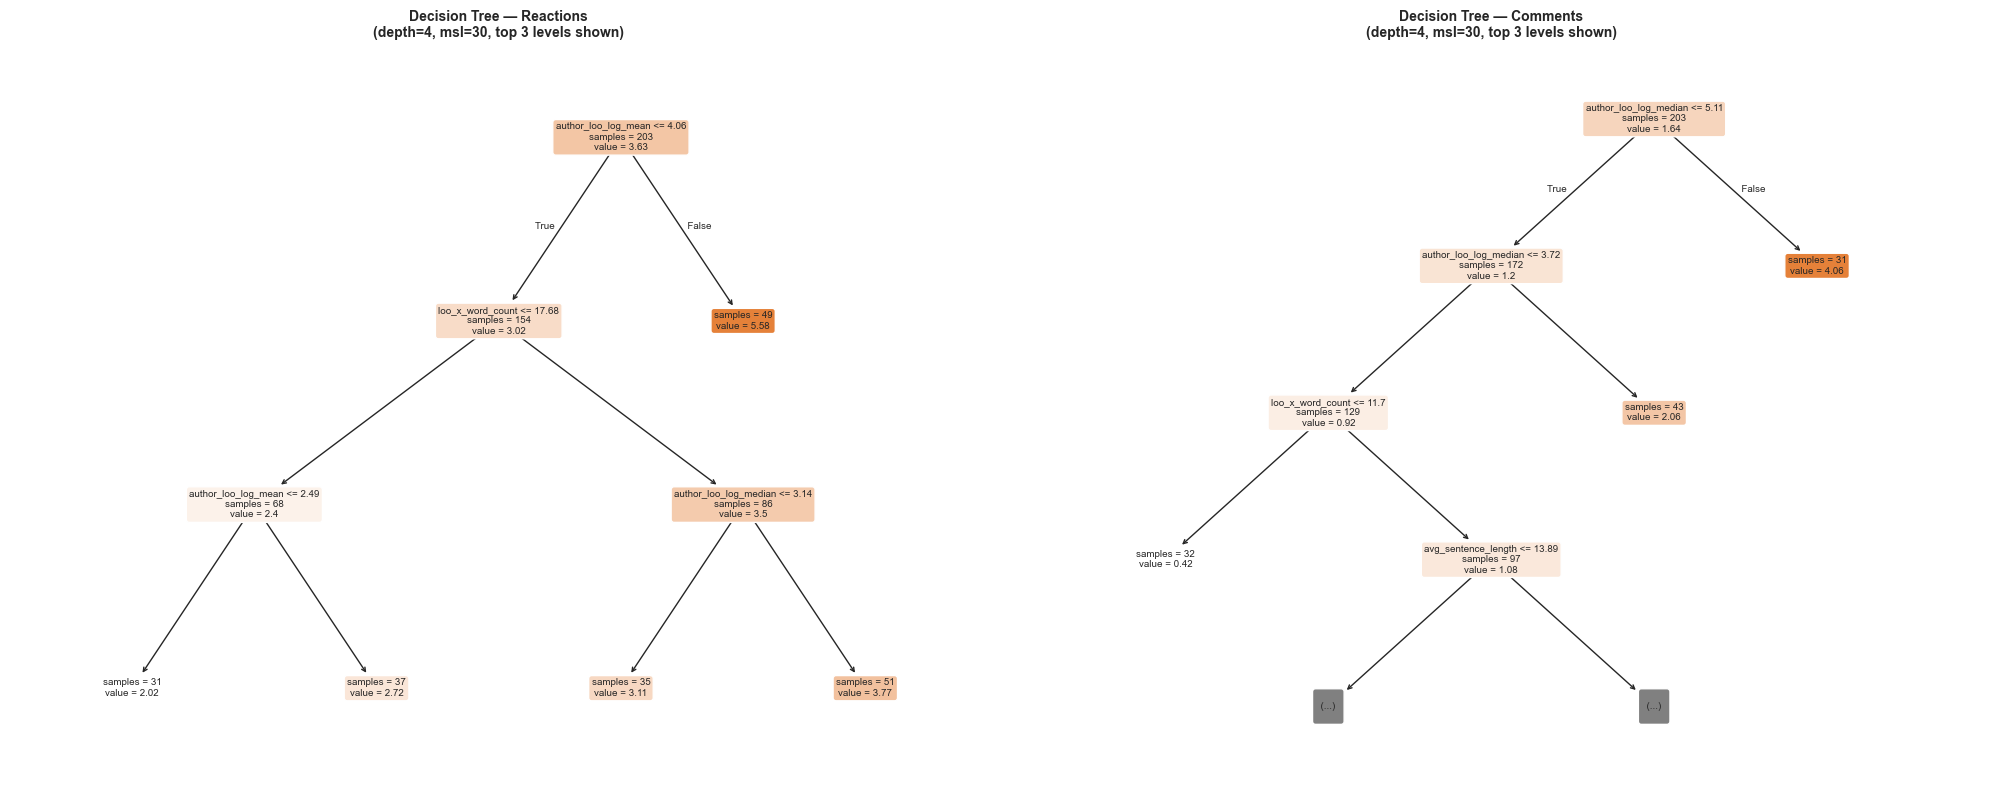

Decision Tree Rules (Reactions, max depth 4):
|--- author_loo_log_mean <= 4.06
|   |--- loo_x_word_count <= 17.68
|   |   |--- author_loo_log_mean <= 2.49
|   |   |   |--- value: [2.02]
|   |   |--- author_loo_log_mean >  2.49
|   |   |   |--- value: [2.72]
|   |--- loo_x_word_count >  17.68
|   |   |--- author_loo_log_median <= 3.14
|   |   |   |--- value: [3.11]
|   |   |--- author_loo_log_median >  3.14
|   |   |   |--- value: [3.77]
|--- author_loo_log_mean >  4.06
|   |--- value: [5.58]



In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Reactions DT
plot_tree(dt, feature_names=feature_names, ax=axes[0],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[0].set_title('Decision Tree — Reactions\n(depth=4, msl=30, top 3 levels shown)',
                   fontweight='bold', fontsize=10)

# Comments DT
plot_tree(dt_c, feature_names=feature_names, ax=axes[1],
          filled=True, rounded=True, fontsize=7, max_depth=3,
          class_names=None, impurity=False, precision=2)
axes[1].set_title('Decision Tree — Comments\n(depth=4, msl=30, top 3 levels shown)',
                  fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Text rules
print('Decision Tree Rules (Reactions, max depth 4):')
print(export_text(dt, feature_names=feature_names, max_depth=4))

## Section 9. Results Summary Table

In [22]:
print('='*80)
print('FINAL RESULTS SUMMARY')
print('='*80)

def summary_df(results):
    rows = []
    for r in results:
        rows.append({
            'Model': r['label'],
            'Log R²': round(r['log_r2'], 4),
            'Log MAE': round(r['log_mae'], 4),
            'MAE (orig)': round(r['mae'], 1),
            'RMSE (orig)': round(r['rmse'], 1),
            'R² (orig)': round(r['r2'], 4),
            'sMAPE (%)': round(r['smape'], 1),
            'MedAE (orig)': round(r['medae'], 1),
        })
    return pd.DataFrame(rows).set_index('Model')

print('\nREACTIONS:')
df_r = summary_df(results_reactions)
print(df_r.to_string())

print('\nCOMMENTS:')
df_c = summary_df(results_comments)
print(df_c.to_string())

best_r = df_r['Log R²'].idxmax()
best_c = df_c['Log R²'].idxmax()
print(f'\nBest for reactions: {best_r}  (Log R²={df_r.loc[best_r, "Log R²"]})')
print(f'Best for comments:  {best_c}  (Log R²={df_c.loc[best_c, "Log R²"]})')

FINAL RESULTS SUMMARY

REACTIONS:
                                         Log R²  Log MAE  MAE (orig)  RMSE (orig)  R² (orig)  sMAPE (%)  MedAE (orig)
Model                                                                                                                
Decision Tree (depth=4, msl=30)          0.6327   0.6714        89.6        216.9     0.2879       61.9          12.5
RF Small (depth=4, msl=30, MAE)          0.5620   0.7916        96.7        243.8     0.1006       72.2          16.6
RF Medium (depth=5, msl=20, MAE)         0.6784   0.6554        82.4        223.4     0.2446       61.5          12.8
RF+ (depth=6, msl=10, mf=0.5, MAE, OOB)  0.8066   0.4971        55.7        170.9     0.5581       49.1          11.2

COMMENTS:
                                         Log R²  Log MAE  MAE (orig)  RMSE (orig)  R² (orig)  sMAPE (%)  MedAE (orig)
Model                                                                                                                
Decision Tr

## Section 10. Predict on New Sample

In [23]:
def predict_engagement(
    followers=10_000,
    connections=500,
    time_spent=30,
    num_hashtags=3,
    media_type='post',
    content="Excited to share that I've just been promoted to Senior Engineer! This journey has been incredible.",
    headline='Senior Software Engineer',
    num_content_links=0,
    author_name=None,           # if None → uses global LOO mean
):
    """
    Predict reactions and comments for a new LinkedIn post.
    If author_name matches an existing author in loo_stats, their personal
    baseline is used — otherwise falls back to the global mean.
    """
    sample = pd.DataFrame([{
        'followers':     followers,
        'connections':   connections,
        'time_spent':    time_spent,
        'num_hashtags':  num_hashtags,
        'media_type':    media_type,
        'content':       content,
        'headline':      headline,
        'content_links': np.nan if num_content_links == 0 else '; '.join(['http://example.com'] * num_content_links),
        'hashtags':      np.nan,
        'name':          author_name if author_name else '__unknown__',
    }])

    X_new = engineer_features(sample, loo_stats).fillna(0)
    for col in feature_names:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[feature_names]

    pred_r_log = rf_plus.predict(X_new)[0]
    pred_c_log = rf_plus_c.predict(X_new)[0]
    pred_reactions = max(0, np.expm1(pred_r_log))
    pred_comments  = max(0, np.expm1(pred_c_log))

    print(f"Author: {author_name or 'unknown (global baseline)'}  |  {followers:,} followers  |  {media_type}  |  {num_hashtags} hashtags")
    print(f"  Predicted reactions: {pred_reactions:.0f}  (log={pred_r_log:.3f})")
    print(f"  Predicted comments:  {pred_comments:.0f}   (log={pred_c_log:.3f})")
    return pred_reactions, pred_comments

# ── Example 1: Known author from the dataset ──────────────────────────────────
# Use an author we trained on so the LOO baseline kicks in
known_author = df['name'].value_counts().index[0]  # author with most posts
known_followers = df[df['name']==known_author]['followers'].iloc[0]
print(f"--- Example 1: Known author '{known_author}' ({known_followers:,} followers) ---")
predict_engagement(
    followers=known_followers, author_name=known_author,
    content='Sharing some thoughts on leadership and growth in uncertain times.',
    num_hashtags=2, media_type='post'
)

# ── Example 2: Unknown author — global baseline ────────────────────────────────
print("\n--- Example 2: Unknown author, large account, personal story ---")
predict_engagement(
    followers=150_000, num_hashtags=5, media_type='post',
    content='After 10 years I finally failed. And that failure taught me everything. I was scared to share this but here it is...'
)

# ── Example 3: Article from mid-size account ──────────────────────────────────
print("\n--- Example 3: Unknown author, article ---")
predict_engagement(
    followers=25_000, num_hashtags=4, media_type='article',
    content='How AI is transforming enterprise software. What every CTO needs to know about machine learning adoption in 2025.'
)

--- Example 1: Known author 'travisbradberry' (2,610,325 followers) ---
Author: travisbradberry  |  2,610,325 followers  |  post  |  2 hashtags
  Predicted reactions: 208  (log=5.341)
  Predicted comments:  32   (log=3.483)

--- Example 2: Unknown author, large account, personal story ---
Author: unknown (global baseline)  |  150,000 followers  |  post  |  5 hashtags
  Predicted reactions: 24  (log=3.237)
  Predicted comments:  2   (log=0.951)

--- Example 3: Unknown author, article ---
Author: unknown (global baseline)  |  25,000 followers  |  article  |  4 hashtags
  Predicted reactions: 24  (log=3.213)
  Predicted comments:  1   (log=0.690)


(23.85628400556268, 0.9929170206594963)